<a href="https://colab.research.google.com/github/oscarcortez/python-data-insider/blob/main/Desafio_Data_Insider_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# hacerlo aparte
import yaml

# Configuration data
config_data = {
    'poligon': {
        'api_key': 'ebSqnJRTvOCSaOUYJz4AlvyaZgIlOl6_',
    }
}

# Write the configuration data to a YAML file
with open('secrets.yaml', 'w') as file:
    yaml.dump(config_data, file)

In [ ]:
!pip install polygon-api-client

In [ ]:
import datetime
import pandas as pd
import os
import yaml
from polygon import RESTClient
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# CREANDO LAS CLASES
class Fortune_Global_500:

  def __init__(self, init_year, end_year):
    self.directory_resource = 'fortune_global_500'
    self.input_path = '/content/drive/MyDrive/alura/inputs'
    self.prefix_file = 'fortune_global_'
    self.html = 'html'
    self.csv = 'csv'
    self.df_fortune_global_list = {}
    self.init_year = init_year
    self.end_year = end_year
    self.df_fortune_global = pd.DataFrame()

  def html_to_dataframe(self):

    for year in range (self.init_year, self.end_year +1):
      per_year_fortune_global = pd.read_html(f'{self.input_path}/{self.html}/{self.directory_resource}/{self.prefix_file}{year}.{self.html}')[0]
      self.df_fortune_global_list[year] = per_year_fortune_global

  def verify_dataframe_list(self):

    print(f'There are {len(self.df_fortune_global_list)} dataframes in the list')

  def dataframe_list_to_csv(self):
    for year in range(self.init_year, self.end_year + 1):
      self.df_fortune_global_list[year].to_csv(f'{self.input_path}/{self.csv}/{self.directory_resource}/{self.prefix_file}{year}.{self.csv}', index = False)

  def verify_csv_files(self):
    directory = f'{self.input_path}/{self.csv}/{self.directory_resource}'
    files_list = os.listdir(directory)
    print(f'There are {len(files_list)} csv files')

  def dataframe_list_spanish_columns(self):
    for year in range(self.init_year, self.end_year + 1):
      self.df_fortune_global_list[year] = self.df_fortune_global_list[year][['RemoveName','RemoveEmployees']]
      spanish_columns = {
        'RemoveName': 'Empresa',
        'RemoveEmployees': 'Empleados'
      }
      self.df_fortune_global_list[year] = self.df_fortune_global_list[year].rename(columns = spanish_columns)
      self.df_fortune_global_list[year]['Año'] = year

  def merge_dataframe_list(self):

    for year in range(self.init_year, self.end_year + 1):

      self.df_fortune_global = pd.concat([self.df_fortune_global, self.df_fortune_global_list[year]])

    self.df_fortune_global.reset_index(drop=True, inplace=True)

fortune_global = Fortune_Global_500(2015, 2022)
fortune_global.html_to_dataframe()
fortune_global.verify_dataframe_list()
fortune_global.dataframe_list_to_csv()
fortune_global.verify_csv_files()
# DATA WRANGLING
# 2. Fortune Global 500 les vas a cambiar únicamente el nombre de las dos columnas que vas a utilizar (Empresa, Empleados) y añadir una nueva columna para el Año
fortune_global.dataframe_list_spanish_columns()
fortune_global.merge_dataframe_list()

There are 8 dataframes in the list
There are 8 csv files


In [ ]:
class Poligon_Stock_Market_Data:
  def __init__(self, stock_markets):
    self.directory_resource = 'StockMarketData'
    self.stock_markets = stock_markets
    self.start_date = '2022-01-01'
    self.end_date = '2022-12-31'
    self.url_api = 'https://api.polygon.io/v2/aggs/ticker'
    self.range_1_day = 'range/1/day'
    self.adjusted = 'true'
    self.sort = 'asc'
    self.limit = '50000'
    self.df_list = {}
    self.df_total = pd.DataFrame()

  def api_to_csv(self):

    with open('secrets.yaml', 'r') as file:
      secrets_data = yaml.load(file, Loader=yaml.FullLoader)
    api_key = config_data['poligon']['api_key']

    for stock_market in self.stock_markets:

      response = requests.get(f'{self.url_api}/{stock_market}/{self.range_1_day}/{self.start_date}/{self.end_date}?adjusted={self.adjusted}&sort={self.sort}&limit={self.limit}&apiKey={api_key}')

      if response.status_code == 200:

        data = response.json()
        self.df_list[stock_market] = pd.DataFrame(data['results'])
        df_stock_market_per_day = self.df_list[stock_market]
        df_stock_market_per_day.to_csv(f'/content/drive/MyDrive/alura/inputs/csv/StockMarketData/stock_market_data_{stock_market}_2022.csv', index = False)

      else:

        print("Error:", response.status_code)

  def verify_csv_files(self):

    directory = f'/content/drive/MyDrive/alura/inputs/csv/StockMarketData/'
    files_list = os.listdir(directory)
    print(f'There are {len(files_list)} csv files')

  def merge_dataframe_list(self):

    for stock_market in self.stock_markets:

      self.df_list[stock_market]['nombre'] = stock_market
      self.df_total = pd.concat([self.df_total, self.df_list[stock_market]])

    self.df_total.reset_index(drop=True, inplace=True)

  def dataframe_set_spanish_columns(self):
    spanish_columns = {
      'c': 'precio_cierre',
      'h': 'precio_mas_alto',
      'l': 'precio_mas_bajo',
      'n': 'numero_transacciones',
      'o': 'precio_apertura',
      'v': 'volumen',
      'vw': 'precio_volumen'
    }

    self.df_total = self.df_total.rename(columns = spanish_columns)

  def dataframe_unix_to_datetime(self):
    self.df_total['fecha'] = pd.to_datetime(self.df_total['t'], unit='ms')
    # self.df_total['fecha'] = self.df_total['fecha'].dt.date
    self.df_total = self.df_total.drop('t', axis=1)



market = Poligon_Stock_Market_Data(['AAPL','MSFT','GOOGL','INTC','ADBE'])
market.api_to_csv()
market.verify_csv_files()
market.merge_dataframe_list()
market.dataframe_set_spanish_columns()
market.dataframe_unix_to_datetime()

There are 5 csv files


In [ ]:
class Forbes_Global:

  def __init__(self, init_date, end_date):
    self.df_forbes_global = pd.DataFrame()
    self.df_forbes_global_2000_list = {}
    self.init_date = init_date
    self.end_date = end_date

  def xls_to_dataframe(self):
      for year in range (self.init_date, self.end_date + 1):
        per_year_forbes_global_2000 = pd.read_excel(f'/content/drive/MyDrive/alura/inputs/xlsx/forbes-global-2000/Forbes Global 2000 - {year}   unified industry.xlsx')
        self.df_forbes_global_2000_list[year] = per_year_forbes_global_2000

  def dataframe_to_csv(self):
      for year in range (self.init_date, self.end_date + 1):
        self.df_forbes_global_2000_list[year].to_csv(f'/content/drive/MyDrive/alura/inputs/csv/forbes-global-2000/forbes-global-2000-{year}.csv', index = False)

  def verify_dataframe_list(self):

    if len(self.df_forbes_global_2000_list) == (self.end_date - self.init_date + 1):

      return True

    return False

  def verify_csv_files(self):
    directory = '/content/drive/MyDrive/alura/inputs/csv/forbes-global-2000'
    files_list = os.listdir(directory)
    if len(files_list) == (self.end_date - self.init_date + 1):
      return True
    return False

  def dataframe_list_spanish_columns(self):

    spanish_columns = {
      'Company': 'Empresa',
      'Industry': 'Industria',
      'Country': 'Pais',
      'Sales': 'Ingresos',
      'Profits': 'Ganancias',
      'Assets': 'Activos',
      'Market_Value': 'Valor_Mercado',
    }

    for year in range (self.init_date, self.end_date + 1):
      self.df_forbes_global_2000_list[year] = self.df_forbes_global_2000_list[year].rename(columns=spanish_columns)

  def dataframe_list_add_columns(self):
    for year in range (self.init_date, self.end_date + 1):
      self.df_forbes_global_2000_list[year]['Margen_Rentabilidad'] = self.df_forbes_global_2000_list[year]['Ganancias'] / self.df_forbes_global_2000_list[year]['Ingresos']
      self.df_forbes_global_2000_list[year]['ROA'] = self.df_forbes_global_2000_list[year]['Ganancias'] / self.df_forbes_global_2000_list[year]['Activos']
      self.df_forbes_global_2000_list[year]['Año'] = year

  def merge_dataframe_list(self, init_year, end_year):

    for year in range(init_year, end_year + 1):
      self.df_forbes_global = pd.concat([self.df_forbes_global, self.df_forbes_global_2000_list[year]])

    self.df_forbes_global.reset_index(drop=True, inplace=True)

forbes_global = Forbes_Global(2008,2022)
forbes_global.xls_to_dataframe()
forbes_global.dataframe_to_csv()
# DATA WRANGLING
# 1. Forbes Global 2000, cambiar los nombres de las columnas (Empresa, Industria, Pais, Ingresos, Ganancias, Activos y Valor de Mercado),
forbes_global.dataframe_list_spanish_columns()
# y crear las siguientes variables (para los datasets de Forbes 2000):
#-Margen de Rentabilidad: Ganancias/Ingresos
#-Rentabilidad de los Activos (ROA): Ganancias/Activos
#-Año: Según el nombre de cada dataset
forbes_global.dataframe_list_add_columns()
# 4 juncion de tablas
# Vas a hacer la junción de todos los datasets de Forbes 2000 desde el año 2015 hasta el año 2022
forbes_global.merge_dataframe_list(2015, 2022)
forbes_global.df_forbes_global.shape

(15998, 11)

In [ ]:
class Continent:

  def __init__(self):

    self.df = pd.DataFrame()

  def load_csv(self):
    self.df = pd.read_csv(f'/content/drive/MyDrive/alura/inputs/csv/continentes_y_paises/continente.csv')

  def dataframe_spanish_columns(self):

    spanish_columns = {
      'Continent_Name': 'Nombre_Continente',
      'Continent_Code': 'Codigo_Continente',
      'Three_Letter_Country_Code': 'Codigo_Pais',
      'Country_Name': 'Nombre_Pais'
    }
    self.df.rename(columns = spanish_columns, inplace= True)

  def fix_duplicates(self):
    self.df = self.df.groupby(['Nombre_Pais','Codigo_Pais']).agg({
      'Nombre_Continente': lambda value: '/'.join(value)
      })
    self.df = self.df.reset_index()

cont = Continent()
cont.load_csv()
# DATA WRANGLING
# Vas a mantener en ambos datasets las columnas del nombre de pais y codigo (3 letras) y en el de continente, vas a mantener el nombre del continente.
cont.dataframe_spanish_columns()
cont.fix_duplicates()
cont.df.head()

,Nombre_Pais,Codigo_Pais,Nombre_Continente
0,"Afghanistan, Islamic Republic of",AFG,Asia
1,"Albania, Republic of",ALB,Europe
2,"Algeria, People's Democratic Republic of",DZA,Africa
3,American Samoa,ASM,Oceania
4,"Andorra, Principality of",AND,Europe


In [ ]:
class Country:

  def __init__(self):
    self.df = pd.DataFrame()

  def load_csv(self):
    self.df = pd.read_csv(f'/content/drive/MyDrive/alura/inputs/csv/continentes_y_paises/country_code.csv')

  def dataframe_spanish_columns(self):
    spanish_columns = {
      'Code': 'Codigo_Pais',
      'Country': 'Nombre_Pais'
    }
    self.df.rename(columns = spanish_columns, inplace= True)

country = Country()
country.load_csv()
# DATA WRANGLING
# Vas a mantener en ambos datasets las columnas del nombre de pais y codigo (3 letras) y en el de continente, vas a mantener el nombre del continente.
country.dataframe_spanish_columns()
country.df.head()

,Nombre_Pais,Codigo_Pais
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,American Samoa,ASM
4,Andorra,AND


In [ ]:
# ANALISIS EXPLORATORIO
# PARTE 1
# 1. Es esencial aclarar que el dataframe principal, del cual vamos a partir para desarrollar el análisis es el de Forbes 2000 - 2022
# 2. Al dataframe indicado, le vamos a añadir los dataframes de continente y de  country_code, seleccionando únicamente las columnas de Continente, Pais y Codigo. Asegúrate de escoger la junción que mantiene todo el primer dataset completo.
# 3. Vas a identificar en que columnas tienes valores faltantes, localizar los registros o las filas con los datos faltantes y tomar una acción de acuerdo con lo que veas (Ejemplo: El nombre del país está escrito de forma incorrecta, hay inconsistencias en la fila, etc).

# PARTE 2
# 1. Vas a concatenar todos los datasets de Forbes 2000 desde el año 2015 hasta el año 2022.
# 2. Tu nuevo dataframe debe contener 16000 filas x 13 columnas:
#'Rank_nr', 'Empresa', 'Industria', 'Pais', 'Ingresos', 'Ganancias', 'Activos', 'Valor_Mercado', 'Ano', 'Margen_Rentabilidad', 'ROA', 'Continente', 'Codigo'

# REVISANDO NOMBRES DE PAISES RAROS EN FORBES

weird_country_names = forbes_global.df_forbes_global[~forbes_global.df_forbes_global['Pais'].isin(country.df['Nombre_Pais'])]
weird_country_names['Pais'].unique()

array(['South Korea', 5855, 21274], dtype=object)

In [ ]:
# actualizando nombre de south korea pq si existe en country con otro nombre
countries_to_update = {
  'South Korea': 'Korea, South',
  }
forbes_global.df_forbes_global = forbes_global.df_forbes_global.replace({"Pais": countries_to_update})
weird_country_names = forbes_global.df_forbes_global[~forbes_global.df_forbes_global['Pais'].isin(country.df['Nombre_Pais'])]
# eliminando los 2 registros con nombre numerico: 5855, 21274
try:

  rows_to_drop = forbes_global.df_forbes_global.query('Pais == 5855 or Pais == 21274').index.tolist()
  forbes_global.df_forbes_global.drop(rows_to_drop, inplace=True)
  forbes_global.df_forbes_global.reset_index(drop=True, inplace=True)

except KeyError:

  print(f"Error: Index does not exist in the DataFrame.")

print('probando de nuevo nombres de paises extranios: (esperado [])')
weird_country_names2 = forbes_global.df_forbes_global[~forbes_global.df_forbes_global['Pais'].isin(country.df['Nombre_Pais'])]
weird_country_names2['Pais'].unique()

probando de nuevo nombres de paises extranios: (esperado [])


array([], dtype=object)

In [ ]:
# revisando cantidad de forbes, no debe variar cuando se haga merge (rebajo en 2 por los dos deletes que hicimos)
forbes_global.df_forbes_global.shape

(15996, 11)

In [ ]:
forbes_global.df_forbes_global = pd.merge(forbes_global.df_forbes_global, country.df, left_on='Pais', right_on = 'Nombre_Pais', how='left')
forbes_global.df_forbes_global.shape
# no vario la cantidad de columnas OK

(15996, 13)

In [ ]:
forbes_global.df_forbes_global = pd.merge(forbes_global.df_forbes_global, cont.df, on = 'Codigo_Pais', how = 'left')
forbes_global.df_forbes_global.shape
# no vario cantidad de columnas OK

(15996, 15)

In [ ]:
forbes_global.df_forbes_global.columns

Index(['Rank_nr', 'Empresa', 'Industria', 'Pais', 'Ingresos', 'Ganancias',
       'Activos', 'Valor_Mercado', 'Margen_Rentabilidad', 'ROA', 'Año',
       'Nombre_Pais_x', 'Codigo_Pais', 'Nombre_Pais_y', 'Nombre_Continente'],
      dtype='object')

In [ ]:
forbes_global.df_forbes_global = forbes_global.df_forbes_global.drop('Nombre_Pais_y', axis=1)
forbes_global.df_forbes_global = forbes_global.df_forbes_global.rename(columns={'Nombre_Pais_x': 'Nombre_Pais'})
forbes_global.df_forbes_global.columns

Index(['Rank_nr', 'Empresa', 'Industria', 'Pais', 'Ingresos', 'Ganancias',
       'Activos', 'Valor_Mercado', 'Margen_Rentabilidad', 'ROA', 'Año',
       'Nombre_Pais', 'Codigo_Pais', 'Nombre_Continente'],
      dtype='object')

In [ ]:
# 1. Vas a hacer la junción de todos los datasets de Forbes 2000 desde el año 2015 hasta el año 2022
print(forbes_global.df_forbes_global.shape)
# con los datasets de Fortune Global 500 que contienen únicamente 4000 filas y 3 columna: 'Ano', 'Empresa', 'Empleados' .
print(fortune_global.df_fortune_global.shape)
# Observación: La junción con los datos de Forbes debe ser utilizando dos columnas como clave que serían 'Ano', 'Empresa', respectivamente.
df_presentation = pd.merge(forbes_global.df_forbes_global , fortune_global.df_fortune_global, on=['Año', 'Empresa'], how='inner')
df_presentation.shape
# 4 junction de datos de tablas y analisis exploratorio terminado

(15996, 14)
(4001, 3)


(2206, 15)

In [ ]:
# 5. CONSULTAS A DATOS
# Forbes 2000 del año 2022:
# 1. ¿Cuál es el Top 10 de países con más empresas en Forbes para el periodo indicado?
forbes_global_2022 = df_presentation.query('Año == 2022')

top_10_pais_mas_empresas = forbes_global_2022.groupby('Pais').size().reset_index(name='Count').sort_values('Count', ascending=False).head(10)
top_10_pais_mas_empresas

,Pais,Count
25,United States,92
14,Japan,30
6,China,26
24,United Kingdom,15
5,Canada,13
9,Germany,13
8,France,11
15,"Korea, South",11
11,India,8
22,Switzerland,6


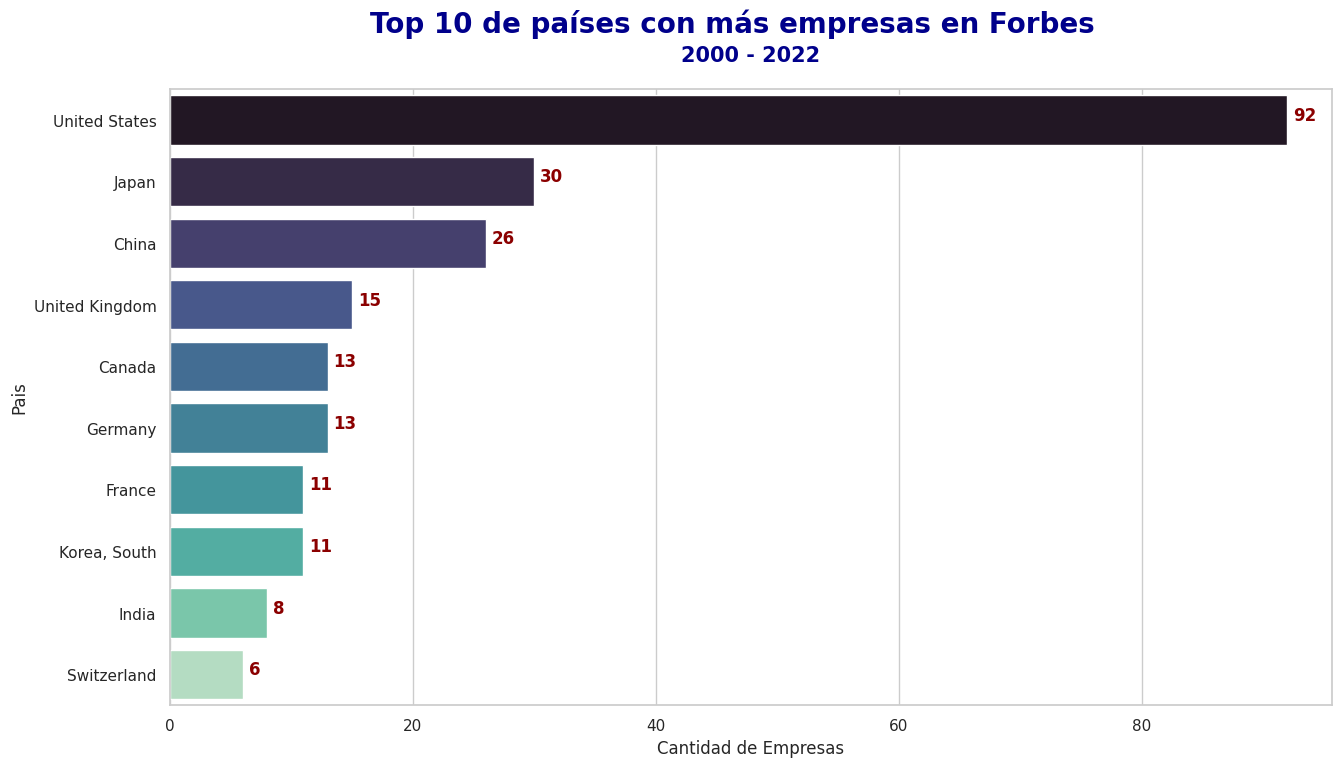

In [ ]:
def graficar_barras(config, tipo):
  fig, ax = plt.subplots(figsize=(15, 8))
  sns.barplot(x= config['barplot_x'], y= config['barplot_y'], palette=config['barplot_palette'])
  fig.suptitle(config['title'],fontsize=20,weight="bold", color= config['title_color'])
  ax.set_title(config['subtitle'], fontsize=15, fontweight='bold', pad=20, color=config['title_color'])
  ax.set_xlabel(config['xlabel'])
  ax.set_ylabel(config['ylabel'])
  if tipo == 'h':
    for i, v in enumerate(config['barplot_x']):
      if v >= 0:
        ax.text(v + config['distancia_resultado_numerico'], i, str(round(v,2)), color='darkred', fontweight='bold')
      else:
        ax.text(v - 0.009 - config['distancia_resultado_numerico'], i, str(round(v,2)), color='darkred', fontweight='bold')
    ax.margins(x=0.04, y=0.01)
  elif tipo == 'v':
    for i, v in enumerate(config['barplot_y']):
      ax.text(i, v + config['distancia_resultado_numerico'], str(round(v,2)), color='darkred', fontweight='bold')
    ax.margins(x=0.04, y=0.06)
  plt.show()

config_top_10_pais_mas_empresas = {
  'barplot_x' : top_10_pais_mas_empresas.Count,
  'barplot_y' : top_10_pais_mas_empresas.Pais,
  'title': 'Top 10 de países con más empresas en Forbes',
  'subtitle': '2000 - 2022',
  'barplot_palette' : 'mako',
  'title_color' : 'darkblue',
  'xlabel': 'Cantidad de Empresas',
  'ylabel': 'Pais',
  'distancia_resultado_numerico': 0.5
}

graficar_barras(config_top_10_pais_mas_empresas, 'h')

In [ ]:
# 2. ¿Cuál es el Top 4 de países con más empresas en el área de tecnología y de telecomunicaciones?
filter_technology = ['Telecommunications services',
                'Telecommunications Services',
                'Technology Hardware & Equipment',
                'IT Software & Services']

technology_companies = forbes_global_2022[forbes_global_2022['Industria'].isin(filter_technology)].groupby('Pais').size().reset_index(name='Count').sort_values('Count', ascending=False).head(4)
technology_companies


,Pais,Count
6,United States,11
5,Taiwan,4
2,Germany,2
4,Japan,2


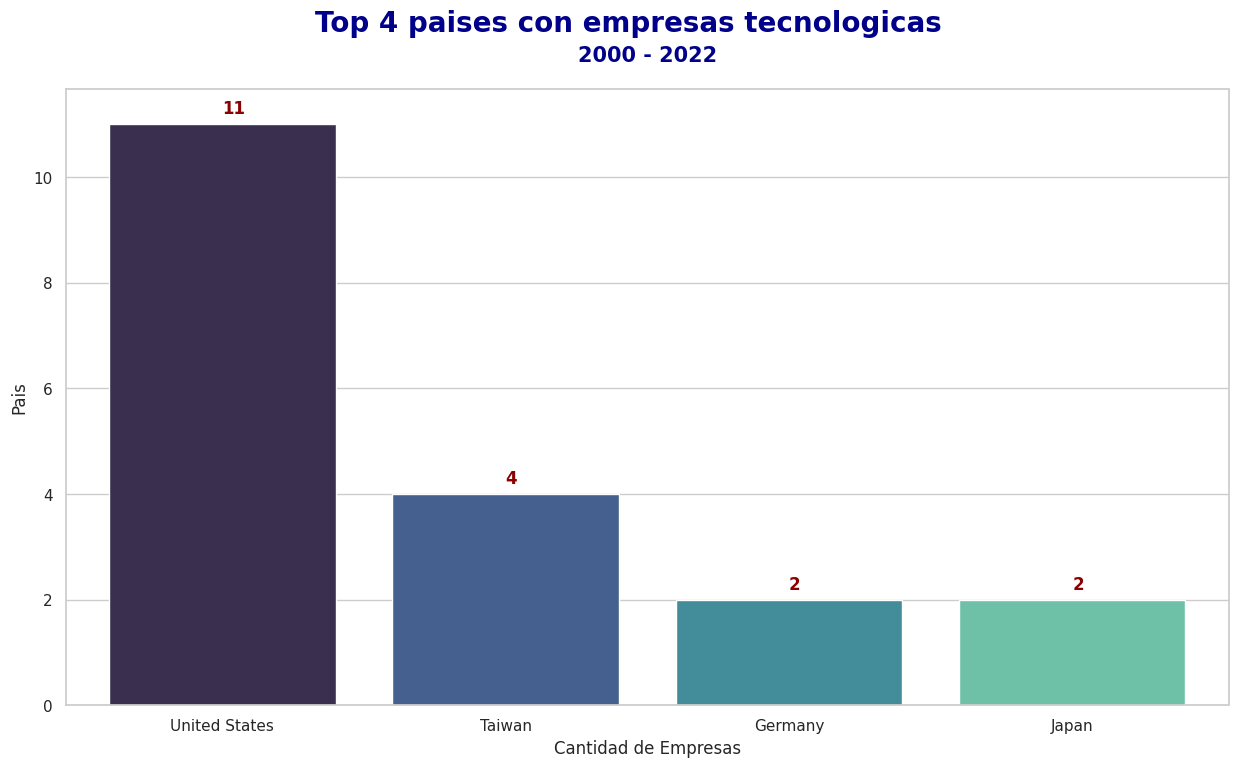

In [ ]:
config_top_4_pais_mas_empresas = {
  'barplot_x' : technology_companies.Pais,
  'barplot_y' : technology_companies.Count,
  'title': 'Top 4 paises con empresas tecnologicas',
  'subtitle': '2000 - 2022',
  'barplot_palette' : 'mako',
  'title_color' : 'darkblue',
  'xlabel': 'Cantidad de Empresas',
  'ylabel': 'Pais',
  'distancia_resultado_numerico': 0.2
}

graficar_barras(config_top_4_pais_mas_empresas, 'v')

In [ ]:
# 3. ¿Cuál fue el margen de pérdida de las 5 empresas que presentaron mayores perjuicios considerando el total de pérdidas registradas
# en la Industria de los Hoteles, Restaurantes y entretenimiento?

forbes_global_2022['Industria'].unique()

top_5_perdidas = forbes_global_2022.query("Industria == 'Hotels, Restaurants & Leisure'").sort_values('Ganancias', ascending = True).head(5)
top_5_perdidas

,Rank_nr,Empresa,Industria,Pais,Ingresos,Ganancias,Activos,Valor_Mercado,Margen_Rentabilidad,ROA,Año,Nombre_Pais,Codigo_Pais,Nombre_Continente,Empleados
2105,303,Starbucks,"Hotels, Restaurants & Leisure",United States,30358.0,4393.1,28834.0,89631.0,0.14471,0.152358,2022,United States,USA,North America,383000


In [ ]:
config_top_10_pais_mas_empresas = {
  'barplot_x' : technology_companies.Pais,
  'barplot_y' : technology_companies.Count,
  'title': 'Top 4 paises con empresas tecnologicas',
  'subtitle': '2000 - 2022',
  'barplot_palette' : 'mako',
  'title_color' : 'darkblue',
  'xlabel': 'Cantidad de Empresas',
  'ylabel': 'Pais',
  'distancia_resultado_numerico': 0.005
}

graficar_barras(config_top_10_pais_mas_empresas, 'v')

In [ ]:
# 4. Considerando a la Industria Petrolera en Asia, ¿Cuál o cuáles empresas superaron en más del 20% su margen de rentabilidad?
rentabilidad_20_df = forbes_global_2022.query("Industria == 'Oil & Gas Operations' and Margen_Rentabilidad > 0.2 and (Nombre_Continente == 'Asia' or Nombre_Continente == 'Europe/Asia')").sort_values('Margen_Rentabilidad', ascending=False)
rentabilidad_20_df


,Rank_nr,Empresa,Industria,Pais,Ingresos,Ganancias,Activos,Valor_Mercado,Margen_Rentabilidad,ROA,Año,Nombre_Pais,Codigo_Pais,Nombre_Continente,Empleados
1978,49,Gazprom,Oil & Gas Operations,Russia,117295.0,25435.6,360474.0,63561.0,0.216852,0.070562,2022,Russia,RUS,Europe/Asia,468000


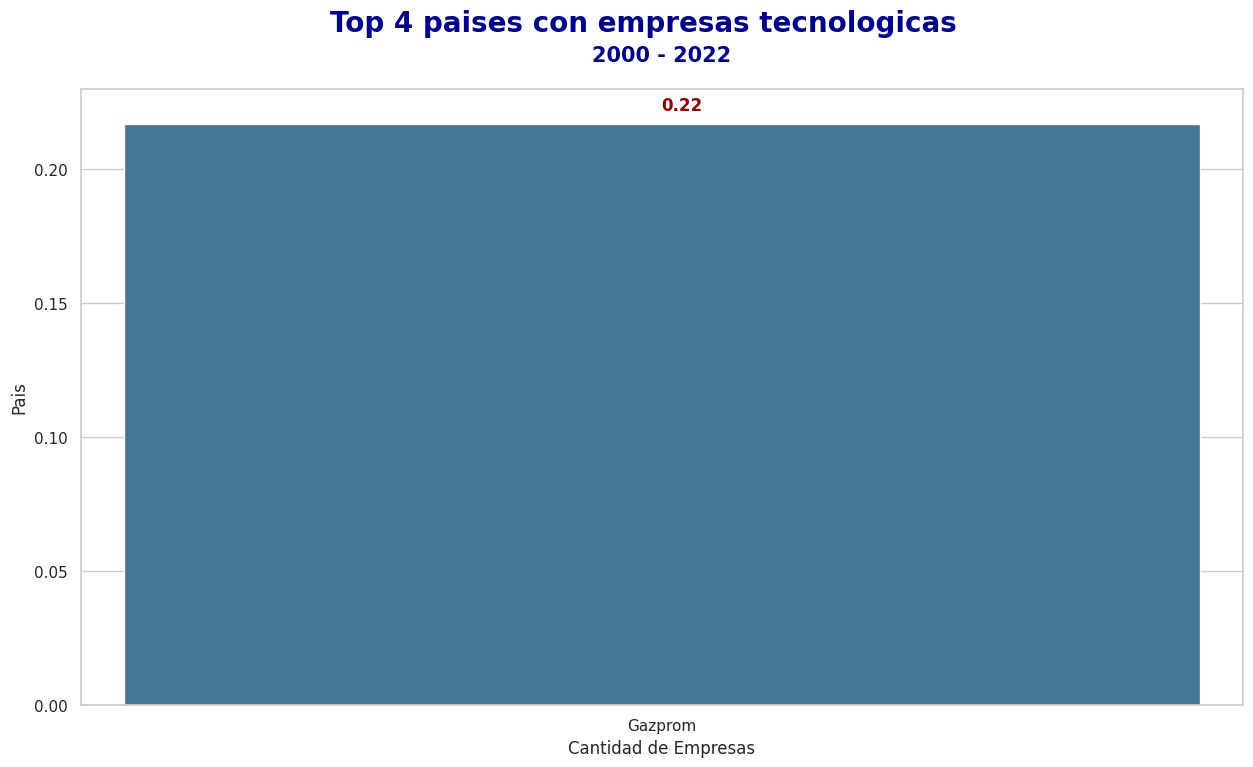

In [ ]:
config_top_10_pais_mas_empresas = {
  'barplot_x' : rentabilidad_20_df.Empresa,
  'barplot_y' : rentabilidad_20_df.Margen_Rentabilidad,
  'title': 'Top 4 paises con empresas tecnologicas',
  'subtitle': '2000 - 2022',
  'barplot_palette' : 'mako',
  'title_color' : 'darkblue',
  'xlabel': 'Cantidad de Empresas',
  'ylabel': 'Pais',
  'distancia_resultado_numerico': 0.005
}

graficar_barras(config_top_10_pais_mas_empresas, 'v')

In [ ]:
# 5. ¿Cuáles fueron las empresas norteamericanas con el mayor porcentaje de rentabilidad por industria?
empresas_con_rentabilidad_por_industria = forbes_global_2022.query('Nombre_Continente == "North America"')
empresas_con_rentabilidad_por_industria = empresas_con_rentabilidad_por_industria.loc[empresas_con_rentabilidad_por_industria.groupby('Industria')['Margen_Rentabilidad'].idxmax()]
empresas_con_rentabilidad_por_industria

,Rank_nr,Empresa,Industria,Pais,Ingresos,Ganancias,Activos,Valor_Mercado,Margen_Rentabilidad,ROA,Año,Nombre_Pais,Codigo_Pais,Nombre_Continente,Empleados
2079,236,Northrop Grumman,Aerospace & Defense,United States,35667.0,7005.0,42579.0,69840.0,0.196400,0.164518,2022,United States,USA,North America,88000
1951,9,Bank of America,Banking,United States,96826.0,30995.0,3238223.0,303102.0,0.320110,0.009572,2022,United States,USA,North America,208248
2116,338,Fannie Mae,Business Services & Supplies,United States,100328.0,22176.0,4229901.0,880.0,0.221035,0.005243,2022,United States,USA,North America,7400
2035,139,Caterpillar,Capital Goods,United States,50984.0,6489.0,82793.0,115913.0,0.127275,0.078376,2022,United States,USA,North America,107700
2063,196,Dow,Chemicals,United States,58350.0,6854.0,63335.0,50353.0,0.117464,0.108218,2022,United States,USA,North America,35700
2045,159,Danaher,Conglomerates,United States,30283.0,6456.0,83392.0,189397.0,0.213189,0.077417,2022,United States,USA,North America,79000
1986,63,Procter & Gamble,Consumer Durables,United States,79618.0,14596.0,120217.0,386528.0,0.183325,0.121414,2022,United States,USA,North America,101000
1946,4,JPMorgan Chase,Diversified Financials,United States,124542.0,42115.0,3954687.0,374446.0,0.338159,0.010649,2022,United States,USA,North America,271025
1977,43,Pfizer,Drugs & Biotechnology,United States,81491.0,21979.0,181476.0,271827.0,0.269711,0.121112,2022,United States,USA,North America,79000
2195,1257,Metro,Food Markets,Canada,14612.0,677.9,10779.0,13230.0,0.046393,0.062891,2022,Canada,CAN,North America,86527


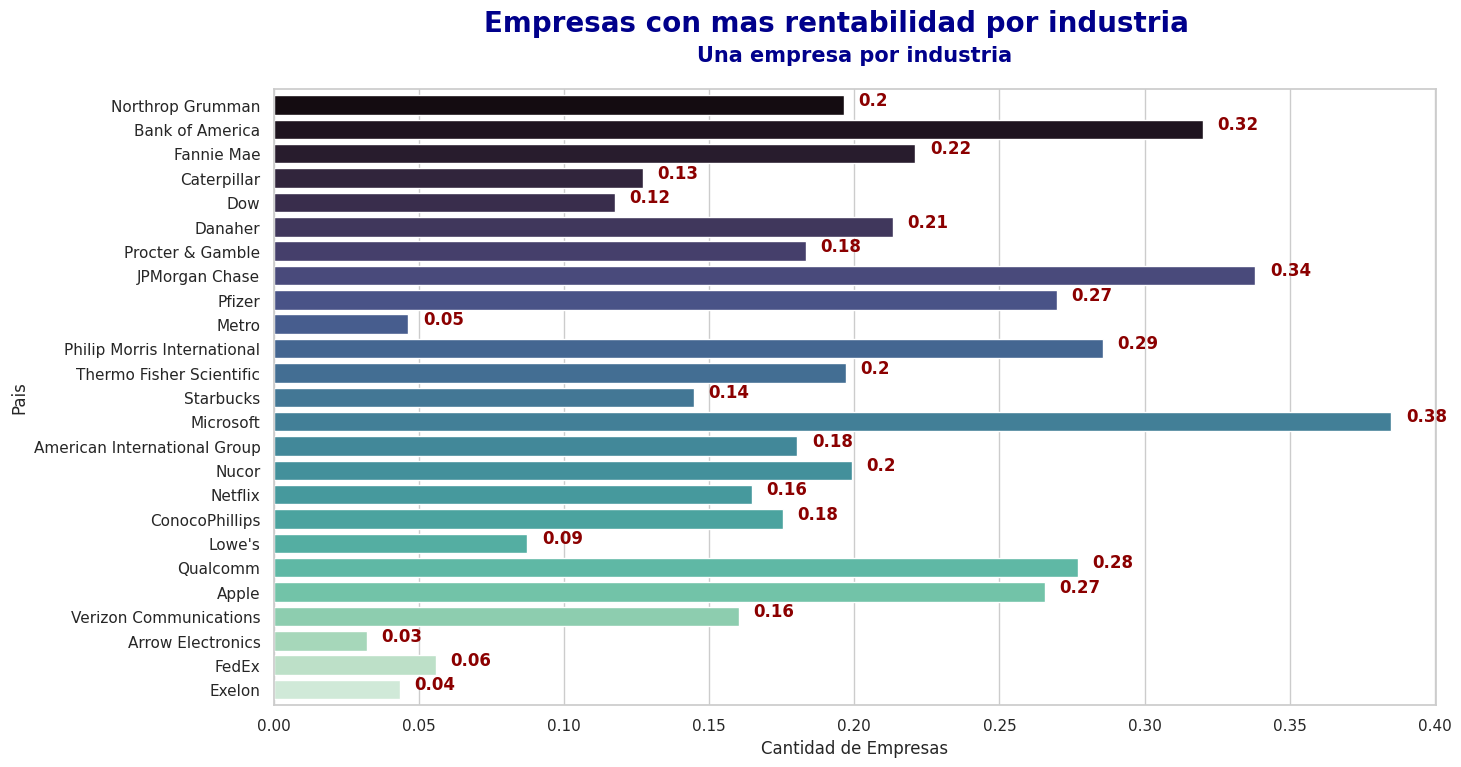

In [ ]:
config_empresas_con_rentabilidad_por_industria = {
  'barplot_x' : empresas_con_rentabilidad_por_industria.Margen_Rentabilidad,
  'barplot_y' : empresas_con_rentabilidad_por_industria.Empresa,
  'title': 'Empresas con mas rentabilidad por industria',
  'subtitle': 'Una empresa por industria',
  'barplot_palette' : 'mako',
  'title_color' : 'darkblue',
  'xlabel': 'Cantidad de Empresas',
  'ylabel': 'Pais',
  'distancia_resultado_numerico': 0.005
}

graficar_barras(config_empresas_con_rentabilidad_por_industria, 'h')

In [ ]:
# 6. Excluyendo a la industria Bancaria, ¿Cuáles fueron las empresas europeas con  mayores pérdidas registradas por industria a nivel global?
not_banking_in_europe = forbes_global_2022.query("Industria != 'Banking' and (Nombre_Continente == 'Europe' or Nombre_Continente == 'Europe/Asia')")
menos_ganancias_por_industria = not_banking_in_europe.loc[not_banking_in_europe.groupby('Industria')['Margen_Rentabilidad'].idxmin()]
menos_ganancias_por_industria

,Rank_nr,Empresa,Industria,Pais,Ingresos,Ganancias,Activos,Valor_Mercado,Margen_Rentabilidad,ROA,Año,Nombre_Pais,Codigo_Pais,Nombre_Continente,Empleados
2185,799,Siemens Energy,Capital Goods,Germany,32514.0,-541.3,51247.0,14432.0,-0.016648,-0.010563,2022,Germany,DEU,Europe,92000
2032,133,BASF,Chemicals,Germany,92901.0,6528.1,102408.0,51781.0,0.070269,0.063746,2022,Germany,DEU,Europe,111047
1999,77,Siemens,Conglomerates,Germany,76464.0,6554.1,164222.0,102228.0,0.085715,0.039910,2022,Germany,DEU,Europe,303000
2152,527,Bouygues,Construction,France,44429.0,1329.7,50767.0,13134.0,0.029929,0.026192,2022,France,FRA,Europe,124651
2171,645,Renault,Consumer Durables,France,54623.0,1049.6,129345.0,7281.0,0.019215,0.008115,2022,France,FRA,Europe,156466
2057,183,ING Group,Diversified Financials,Netherlands,21488.0,5646.3,1081807.0,39035.0,0.262765,0.005219,2022,Netherlands,NLD,Europe,57660
2141,462,AstraZeneca,Drugs & Biotechnology,United Kingdom,38680.0,94.7,105363.0,204560.0,0.002448,0.000899,2022,United Kingdom,GBR,Europe,83100
2145,473,Carrefour,Food Markets,France,87805.0,1267.1,54208.0,15771.0,0.014431,0.023375,2022,France,FRA,Europe,319565
2114,331,Danone,"Food, Drink & Tobacco",France,28654.0,2243.4,51652.0,37968.0,0.078293,0.043433,2022,France,FRA,Europe,98105
2117,339,Fresenius,Health Care Equipment & Services,Germany,44262.0,2148.8,81835.0,20426.0,0.048547,0.026258,2022,Germany,DEU,Europe,281011


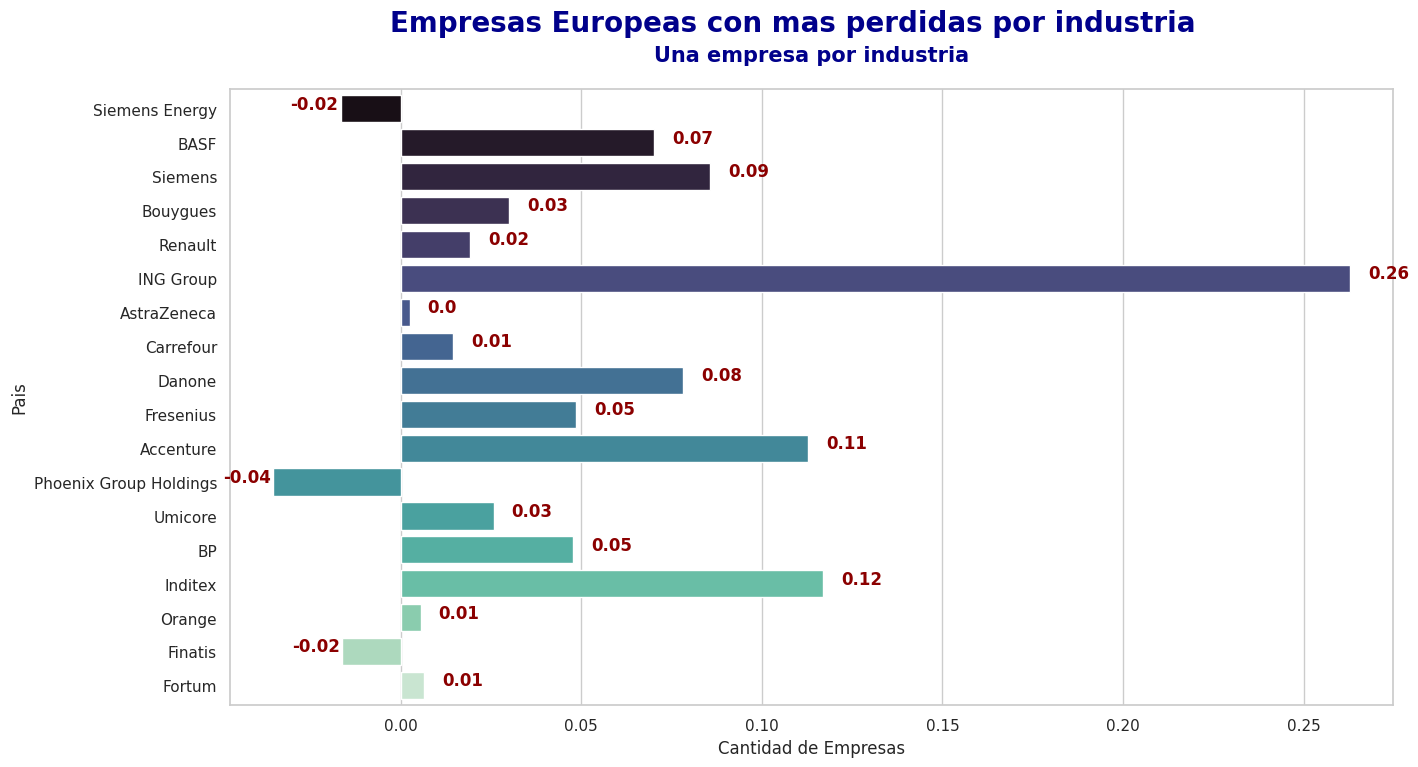

In [398]:
config_menos_ganancias_por_industria = {
  'barplot_x' : menos_ganancias_por_industria.Margen_Rentabilidad,
  'barplot_y' : menos_ganancias_por_industria.Empresa,
  'title': 'Empresas Europeas con mas perdidas por industria',
  'subtitle': 'Una empresa por industria',
  'barplot_palette' : 'mako',
  'title_color' : 'darkblue',
  'xlabel': 'Cantidad de Empresas',
  'ylabel': 'Pais',
  'distancia_resultado_numerico': 0.005
}

graficar_barras(config_menos_ganancias_por_industria, 'h')

In [ ]:
# 7. ¿Cuál fue la distribución de Ingresos y Activos con respecto a las ganancias de los bancos cuyos activos no superan los 30000 millones de dólares?
menos_ganancias_por_industria = forbes_global_2022.query('Activos <= 3000000000 and Industria == "Banking"')[['Empresa','Ingresos', 'Activos', 'Ganancias']]
menos_ganancias_por_industria

,Empresa,Ingresos,Activos,Ganancias
1947,China Construction Bank,202069.0,4746951.0,46887.3
1950,Agricultural Bank of China,181420.0,4561048.0,37378.5
1951,Bank of America,96826.0,3238223.0,30995.0
1955,Bank of China,152425.0,4192836.0,33574.4
1958,Wells Fargo,84123.0,1939709.0,20583.0
1963,China Merchants Bank,71066.0,1451202.0,18584.4
1972,HSBC Holdings,59326.0,2957939.0,12577.5
1973,BNP Paribas,127425.0,2995890.0,9848.3
1985,Bank of Communications,75998.0,1830396.0,12981.6
2006,Bank of Nova Scotia,30353.0,979300.0,7955.5


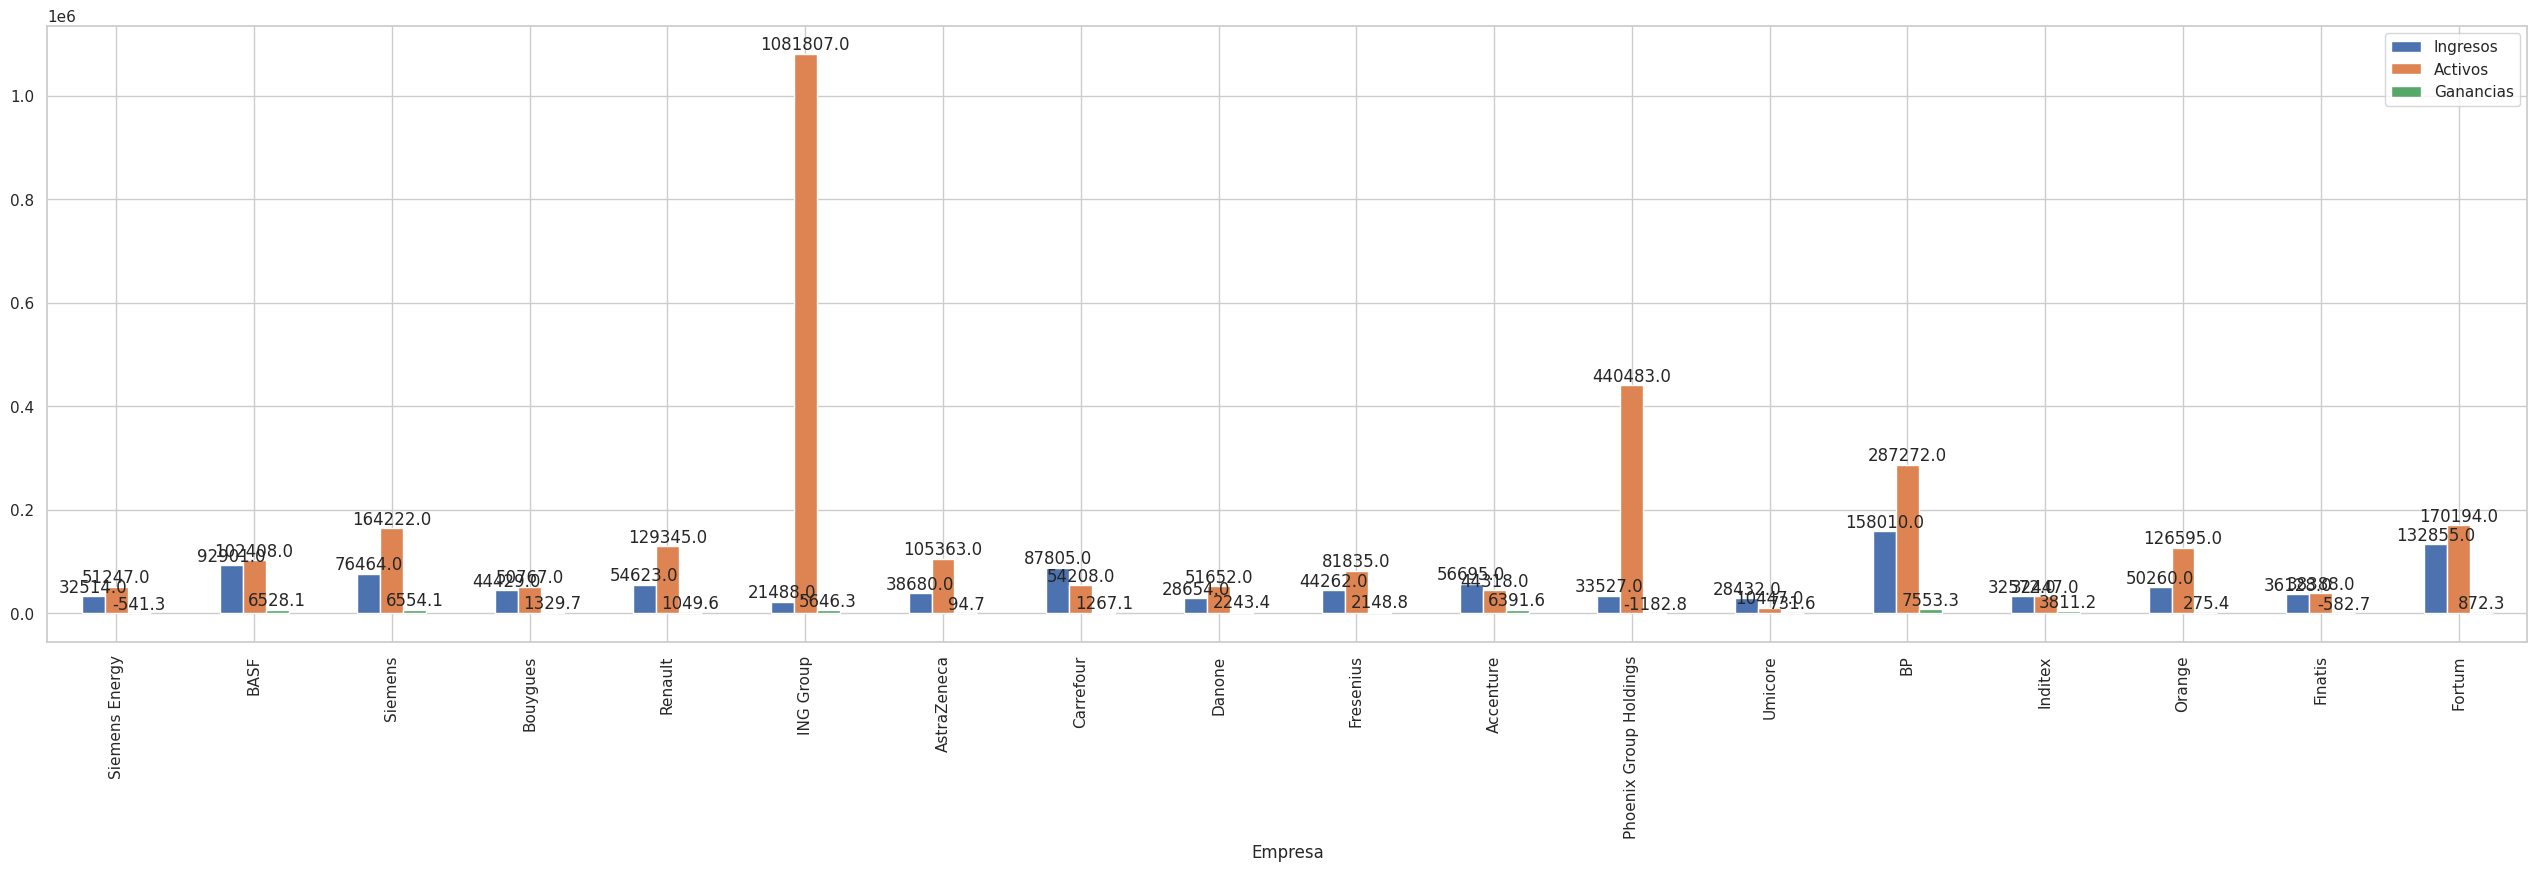

In [ ]:
#df=pd.DataFrame(menos_ganancias_por_industria,columns=["Empresa","Ingresos","Activos","Ganancias"])

ax = menos_ganancias_por_industria.plot(x="Empresa", y=["Ingresos", "Activos", "Ganancias"], kind="bar",figsize=(32,8))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.show()

In [ ]:
# 8. Considerando el histórico de valores de las acciones en el año 2022 de las 5 empresas de tu elección (Paso 2),
# Indica ¿Cuál fue la mejor semana para comprar y cuál para vender respectivamente? (Se compra cuando el precio es bajo, y se vende cuando el precio es alto)

#revision de las 5 empresas
market.df_total['nombre'].value_counts()


AAPL     251
MSFT     251
GOOGL    251
INTC     251
ADBE     251
Name: nombre, dtype: int64

In [ ]:
# revision del dataframe columns and indexes and date column
market.df_total

,volumen,precio_volumen,precio_apertura,precio_cierre,precio_mas_alto,precio_mas_bajo,numero_transacciones,nombre,fecha
0,104677470.0,181.4156,177.83,182.01,182.88,177.7100,772691,AAPL,2022-01-03 05:00:00
1,99110438.0,180.5574,182.63,179.70,182.94,179.1200,831890,AAPL,2022-01-04 05:00:00
2,94535602.0,177.2884,179.61,174.92,180.17,174.6400,848513,AAPL,2022-01-05 05:00:00
3,96882954.0,173.0800,172.70,172.00,175.30,171.6400,960340,AAPL,2022-01-06 05:00:00
4,86709147.0,172.4383,172.89,172.17,174.14,171.0300,716881,AAPL,2022-01-07 05:00:00
...,...,...,...,...,...,...,...,...,...
1250,1629781.0,337.1283,335.00,338.45,338.92,333.2850,47967,ADBE,2022-12-23 05:00:00
1251,1464308.0,335.3587,338.00,335.09,338.16,332.4600,40581,ADBE,2022-12-27 05:00:00
1252,1672063.0,330.6436,335.06,328.33,338.50,327.1900,45711,ADBE,2022-12-28 05:00:00
1253,1793051.0,337.0168,330.75,337.58,339.50,329.7604,44402,ADBE,2022-12-29 05:00:00


In [ ]:
# el precio de cierre promedio semanal
df_market = pd.DataFrame(market.df_total)
df_market.set_index('fecha', inplace=True)
weekly_average = df_market.groupby(['nombre', pd.Grouper(freq='W')])['precio_cierre'].mean()
df_weekly_average = weekly_average.reset_index()

In [ ]:
# extraer el precio de semana mas alto de cada empresa (5 empresas en total)
precio_semana_cierre_mas_alto = df_weekly_average.loc[df_weekly_average.groupby('nombre')['precio_cierre'].idxmax()]
precio_semana_cierre_mas_alto.rename(columns={'fecha': 'semana venta', 'precio_cierre': 'promedio precio venta'}, inplace=True)
precio_semana_cierre_mas_alto.set_index('nombre', inplace=True)

# extraer el precio de semana mas bajo de cada empresa (5 empresas en total)
precio_semana_cierre_mas_bajo = df_weekly_average.loc[df_weekly_average.groupby('nombre')['precio_cierre'].idxmin()]
precio_semana_cierre_mas_bajo.rename(columns={'fecha': 'semana compra', 'precio_cierre': 'promedio precio compra'}, inplace=True)
precio_semana_cierre_mas_bajo.set_index('nombre', inplace=True)

# concatenamos/merge/unir el resultado
df_mejores_semanas_market = pd.concat([precio_semana_cierre_mas_alto, precio_semana_cierre_mas_bajo], axis=1)
df_mejores_semanas_market = df_mejores_semanas_market.reset_index()
df_mejores_semanas_market

,nombre,semana venta,promedio precio venta,semana compra,promedio precio compra
0,AAPL,2022-04-03,176.2500,2023-01-01,128.9025
1,ADBE,2022-01-09,531.5240,2022-10-02,277.8760
2,GOOGL,2022-02-06,141.4661,2023-01-01,87.5225
3,INTC,2022-01-16,55.5000,2022-10-16,25.5800
4,MSFT,2022-01-09,321.6120,2022-11-06,223.2080


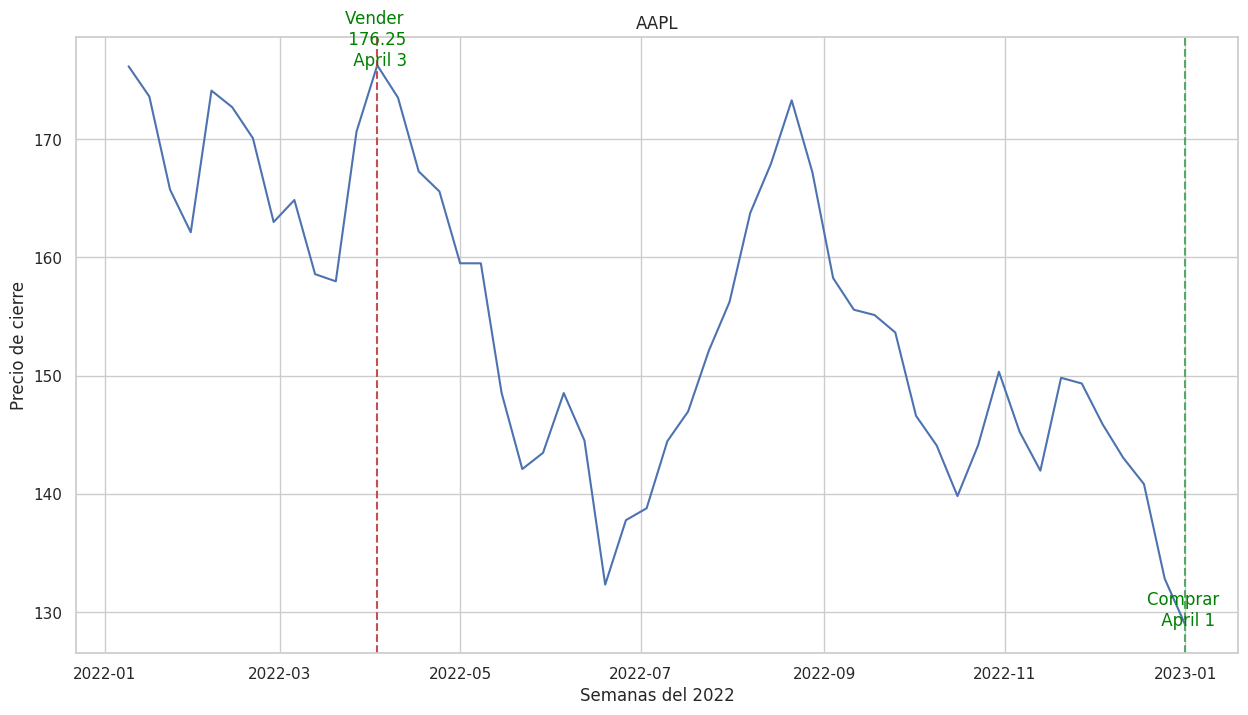

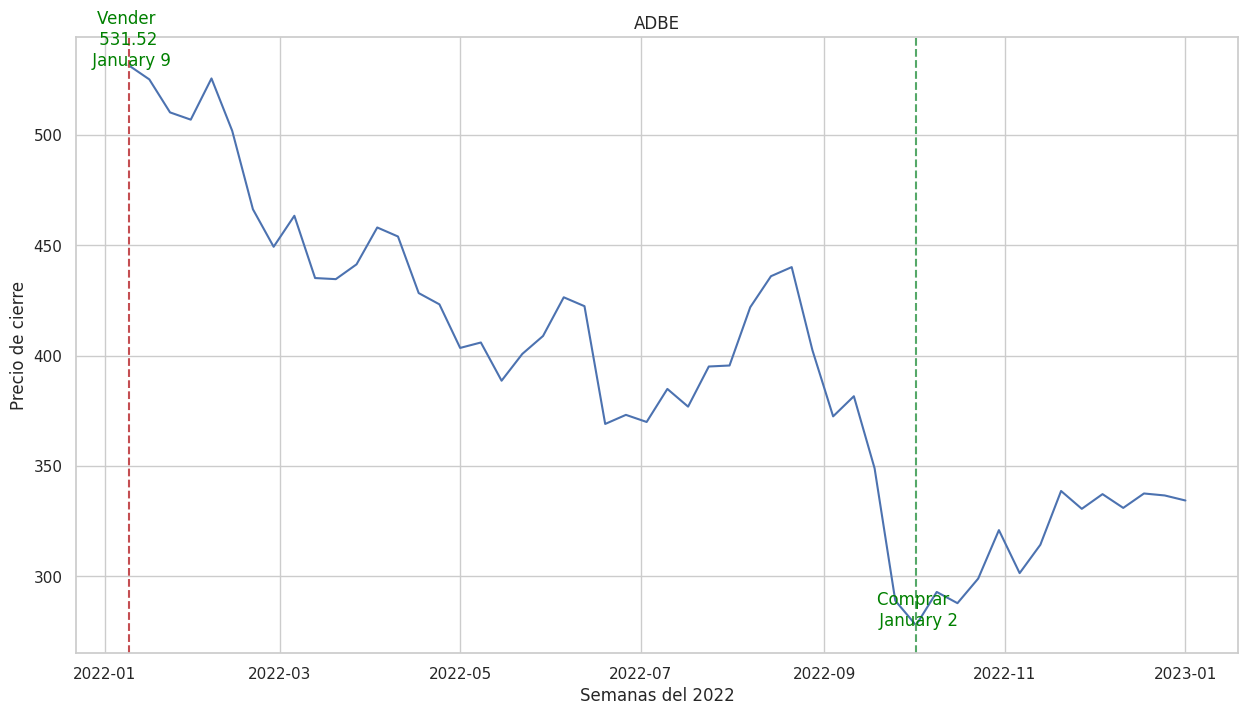

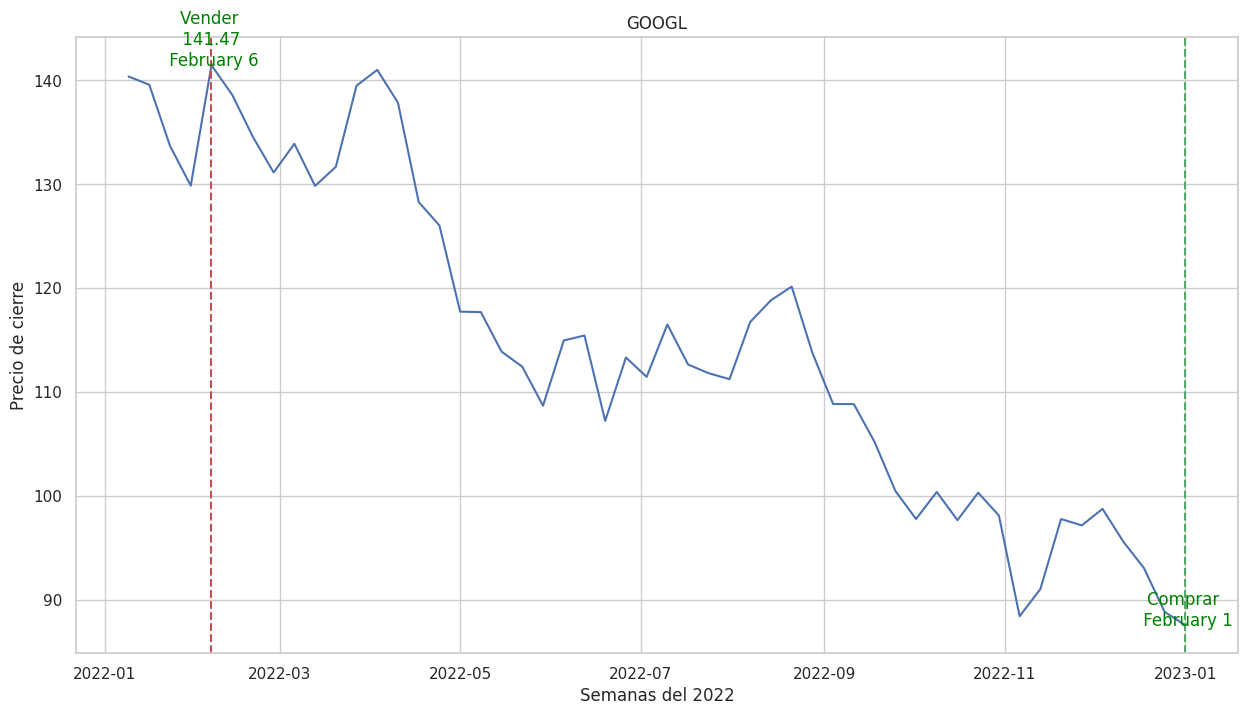

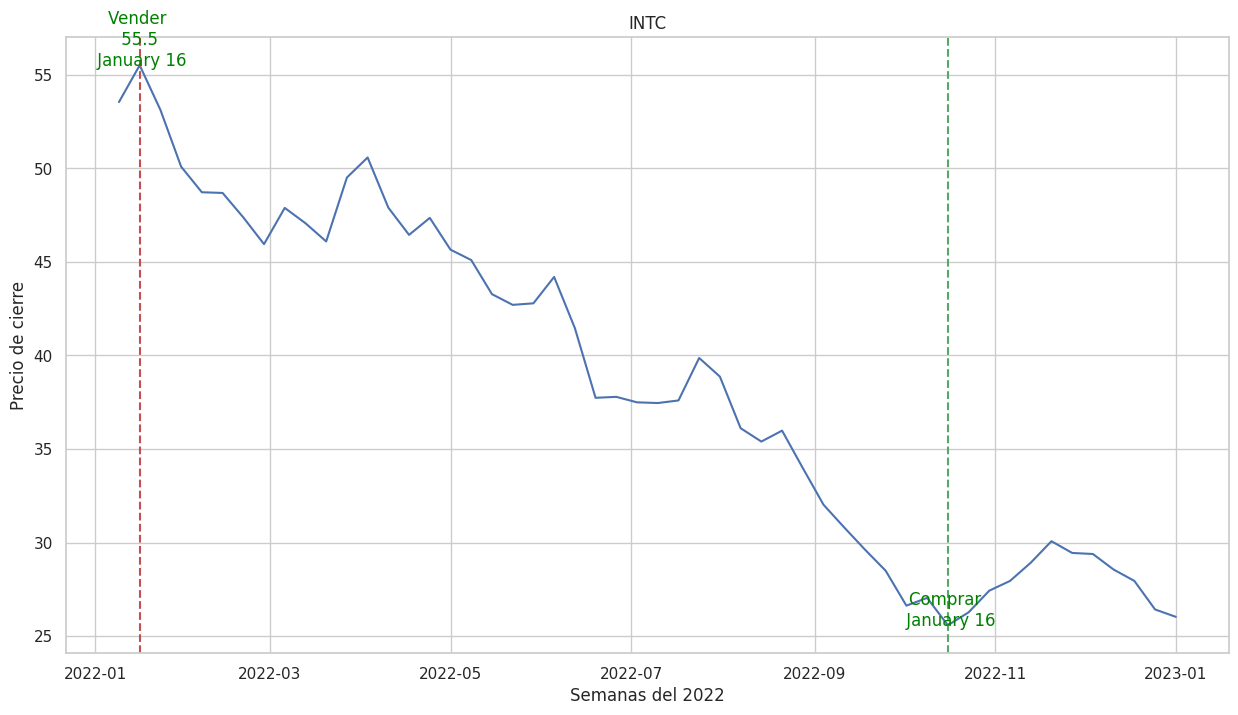

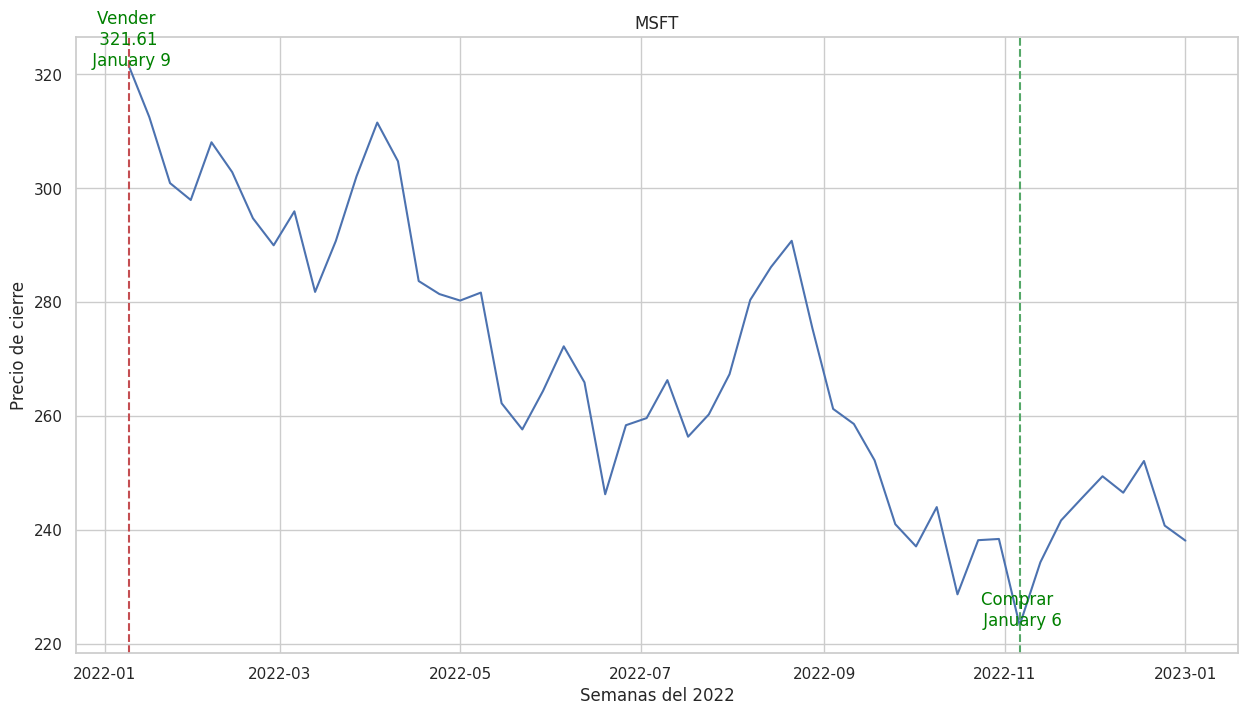

In [ ]:
for index, row in df_mejores_semanas_market.iterrows():

  df_weekly_average_company = df_weekly_average.query(f"nombre == '{row['nombre']}'")
  plt.figure(figsize=(15, 8))
  sns.lineplot(x=df_weekly_average_company['fecha'], y=df_weekly_average_company['precio_cierre'])
  fecha_semana_venta = pd.to_datetime(row['semana venta'])
  promedio_precio_venta = round(row['promedio precio venta'],2)
  mostrar_fecha_semana_venta = f'{fecha_semana_venta.strftime("%B")} {fecha_semana_venta.day}'
  plt.text(fecha_semana_venta, row['promedio precio venta'], f'Vender \n {promedio_precio_venta} \n {mostrar_fecha_semana_venta}', fontsize=12, ha='center', color = 'green')
  plt.axvline(x=fecha_semana_venta, color='r', linestyle='--')
  fecha_semana_compra = pd.to_datetime(row['semana compra'])
  promedio_precio_compra = round(row['promedio precio compra'],2)
  mostrar_fecha_semana_compra = f'{fecha_semana_venta.strftime("%B")} {fecha_semana_compra.day}'
  plt.text(fecha_semana_compra, row['promedio precio compra'], f'Comprar \n {mostrar_fecha_semana_compra}', fontsize=12, ha='center', color = 'green')
  plt.axvline(x=fecha_semana_compra, color='g', linestyle='--')
  plt.xlabel('Semanas del 2022')
  plt.ylabel('Precio de cierre')
  plt.title(row['nombre'])
  plt.show()
  print()




Cuestionario B

Las siguientes preguntas se refieren al ranking Forbes 2000 considerando el periodo 2015 - 2022:

In [ ]:
# 1. ¿Cuál es el Top 10 de países con más empresas en Forbes para el periodo indicado?
top_10_pais_mas_empresas_2 = df_presentation.groupby('Pais').size().reset_index(name='Count').sort_values('Count', ascending=False).head(10)
top_10_pais_mas_empresas_2

,Pais,Count
29,United States,765
16,Japan,289
7,China,182
28,United Kingdom,133
10,France,121
11,Germany,116
17,"Korea, South",90
5,Canada,72
13,India,56
25,Switzerland,51


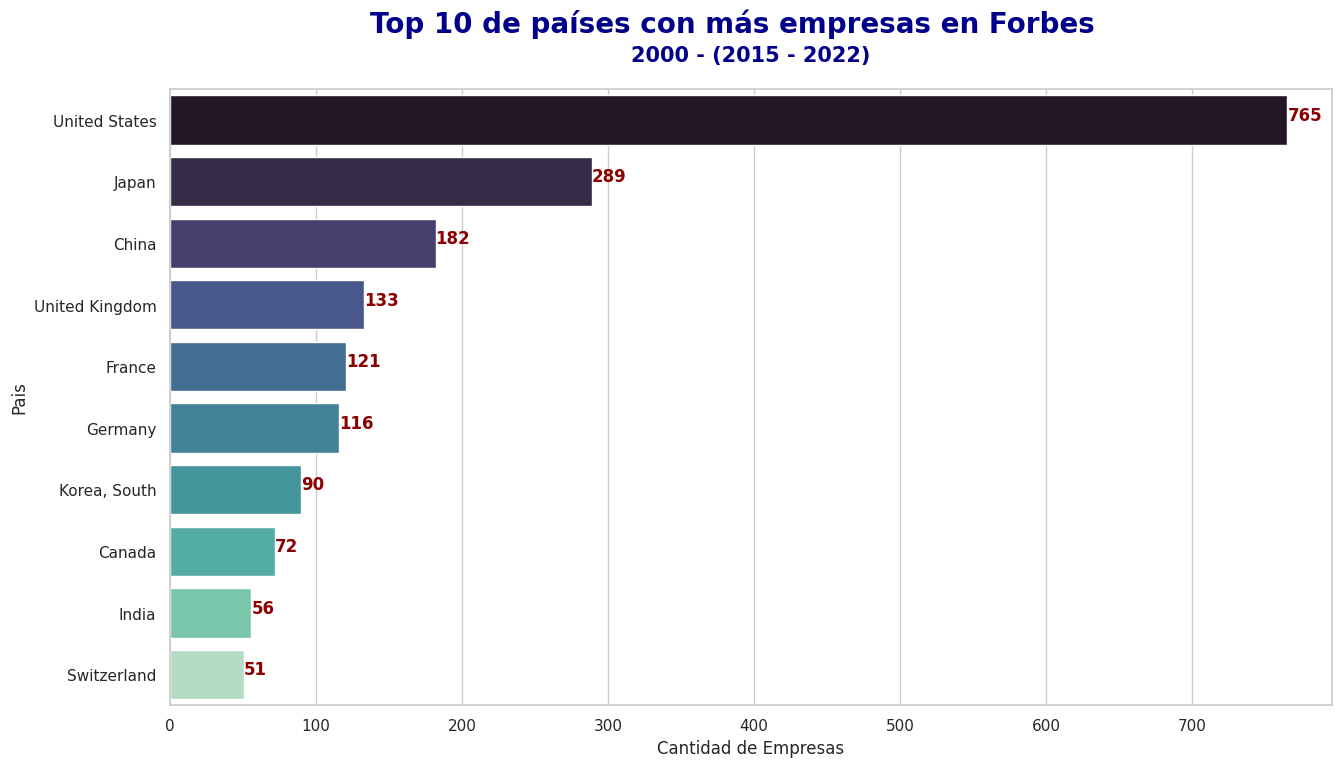

In [ ]:
config_top_10_pais_mas_empresas_2 = {
    'barplot_x' : top_10_pais_mas_empresas_2.Count,
    'barplot_y' : top_10_pais_mas_empresas_2.Pais,
    'title': 'Top 10 de países con más empresas en Forbes',
    'subtitle': '2000 - (2015 - 2022)',
    'barplot_palette' : 'mako',
    'title_color' : 'darkblue',
    'xlabel': 'Cantidad de Empresas',
    'ylabel': 'Pais',
    'distancia_resultado_numerico': 0.07
}

graficar_barras(config_top_10_pais_mas_empresas_2,'h')

In [ ]:
# 2. ¿Cuál es el Top 5 de países con más empresas en el área de tecnología y de telecomunicaciones?
filter_technology_2 = ['Telecommunications services',
                'Telecommunications Services',
                'Technology Hardware & Equipment',
                'IT Software & Services']

technology_companies_2 = df_presentation[df_presentation['Industria'].isin(filter_technology)].groupby('Pais').size().reset_index(name='Count').sort_values('Count', ascending=False).head(5)
technology_companies_2

,Pais,Count
15,United States,82
13,Taiwan,25
8,Japan,20
4,Germany,15
1,China,10


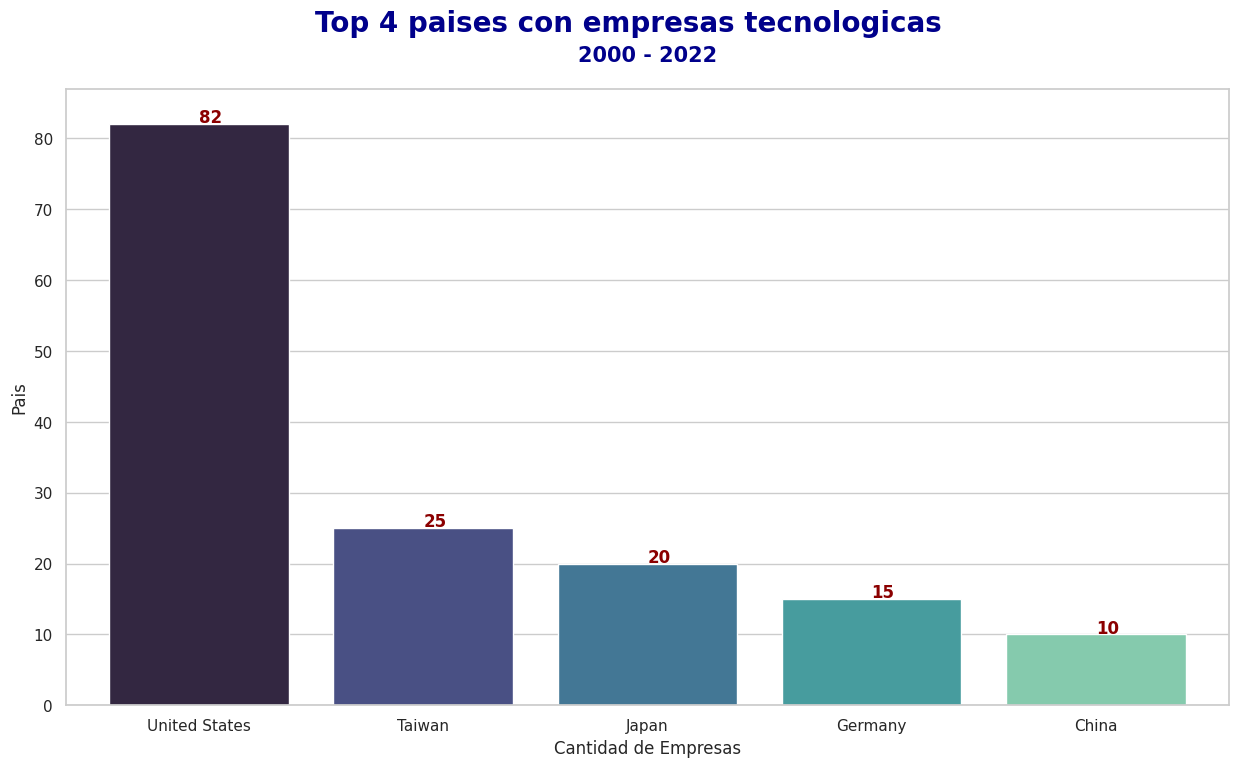

In [385]:
config_top_4_pais_mas_empresas_2 = {
  'barplot_x' : technology_companies_2.Pais,
  'barplot_y' : technology_companies_2.Count,
  'title': 'Top 4 paises con empresas tecnologicas',
  'subtitle': '2000 - 2022',
  'barplot_palette' : 'mako',
  'title_color' : 'darkblue',
  'xlabel': 'Cantidad de Empresas',
  'ylabel': 'Pais',
  'distancia_resultado_numerico': 0.2
}

graficar_barras(config_top_4_pais_mas_empresas_2, 'v')

In [392]:
# 3. ¿Cuál fue el margen de pérdida de las 10 empresas que presentaron mayores perjuicios considerando el total de pérdidas registradas en la Industria de los Hoteles, Restaurantes y entretenimiento?
top_5_perdidas_2 = df_presentation.query("Industria == 'Hotels, Restaurants & Leisure'").sort_values('Ganancias', ascending = True).head(10)
top_5_perdidas_2

,Rank_nr,Empresa,Industria,Pais,Ingresos,Ganancias,Activos,Valor_Mercado,Margen_Rentabilidad,ROA,Año,Nombre_Pais,Codigo_Pais,Nombre_Continente,Empleados
1920,793,Compass Group,"Hotels, Restaurants & Leisure",United Kingdom,25407.0,169.5,19048.0,39158.0,0.006671,0.008899,2021,United Kingdom,GBR,Europe,548143
486,467,Compass Group,"Hotels, Restaurants & Leisure",United Kingdom,27165.0,1342.0,13250.0,28878.0,0.049402,0.101283,2016,United Kingdom,GBR,Europe,515864
787,486,Compass Group,"Hotels, Restaurants & Leisure",United Kingdom,27823.0,1407.8,13694.0,31115.0,0.050598,0.102804,2017,United Kingdom,GBR,Europe,527180
1626,505,Compass Group,"Hotels, Restaurants & Leisure",United Kingdom,31737.0,1416.0,16402.0,26763.0,0.044617,0.086331,2020,United Kingdom,GBR,Europe,596452
213,492,Compass Group,"Hotels, Restaurants & Leisure",United Kingdom,28250.0,1432.5,14094.0,29409.0,0.050708,0.101639,2015,United Kingdom,GBR,Europe,514718
1356,498,Compass Group,"Hotels, Restaurants & Leisure",United Kingdom,30866.0,1512.0,16447.0,35470.0,0.048986,0.091932,2019,United Kingdom,GBR,Europe,595841
1088,517,Compass Group,"Hotels, Restaurants & Leisure",United Kingdom,29780.0,1513.3,15996.0,32365.0,0.050816,0.094605,2018,United Kingdom,GBR,Europe,588112
1573,288,Starbucks,"Hotels, Restaurants & Leisure",United States,26656.0,3389.8,27479.0,89628.0,0.127168,0.123360,2020,United States,USA,North America,346000
2105,303,Starbucks,"Hotels, Restaurants & Leisure",United States,30358.0,4393.1,28834.0,89631.0,0.144710,0.152358,2022,United States,USA,North America,383000
701,215,McDonald's,"Hotels, Restaurants & Leisure",United States,24622.0,4660.3,31024.0,106436.0,0.189274,0.150216,2017,United States,USA,North America,375000


In [ ]:
# 4. Considerando a la Industria Petrolera en las Américas, ¿Cuál o cuáles empresas superaron en más del 20% la rentabilidad de sus activos?
rentabilidad_20_df_2 = df_presentation.query("Industria == 'Oil & Gas Operations' and Margen_Rentabilidad > 0.2 and (Nombre_Continente == 'North America' or Nombre_Continente == 'South America')").sort_values('Margen_Rentabilidad', ascending=False)
rentabilidad_20_df_2

,Rank_nr,Empresa,Industria,Pais,Ingresos,Ganancias,Activos,Valor_Mercado,Margen_Rentabilidad,ROA,Año,Nombre_Pais,Codigo_Pais,Nombre_Continente,Empleados
1988,65,Petrobras,Oil & Gas Operations,Brazil,83887.0,19767.3,174677.0,83981.0,0.235642,0.113165,2022,Brazil,BRA,South America,45532


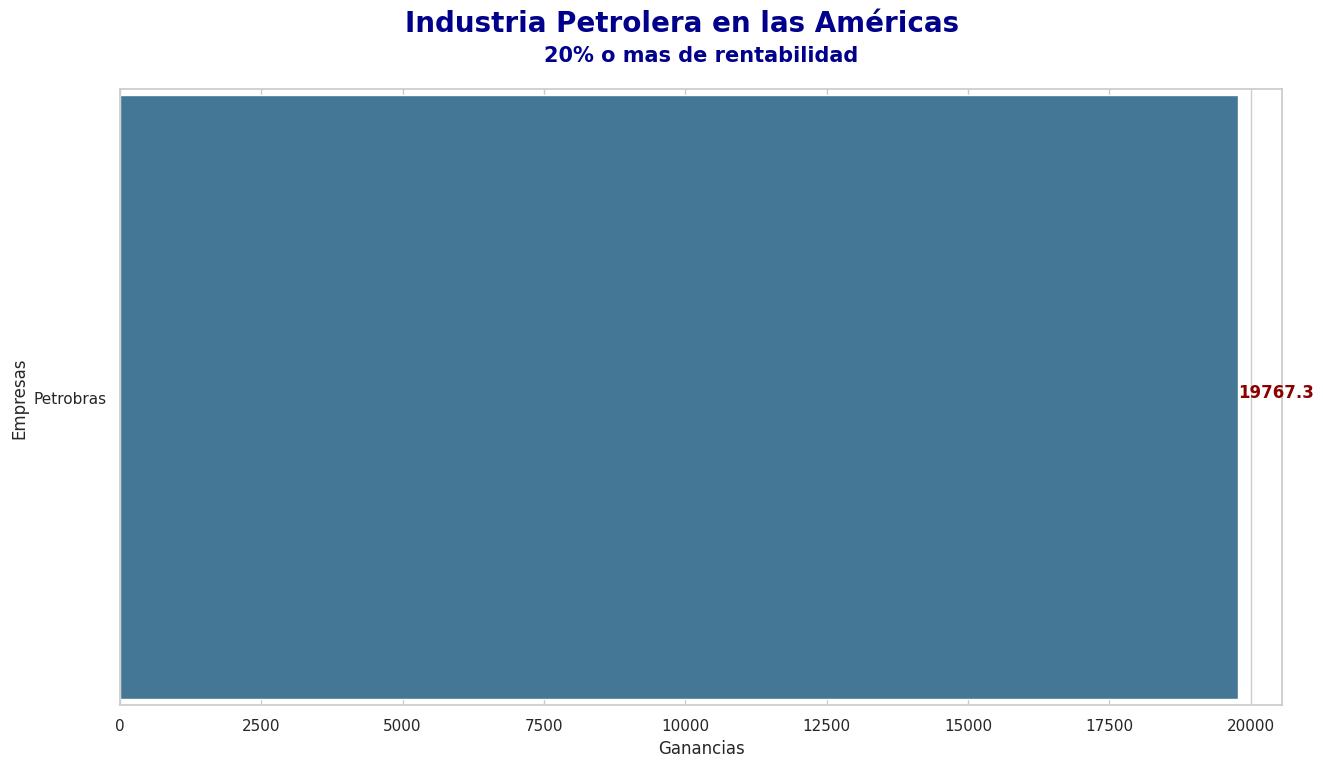

In [406]:
config_rentabilidad_20_df_2 = {
  'barplot_x' : rentabilidad_20_df_2.Ganancias,
  'barplot_y' : rentabilidad_20_df_2.Empresa,
  'title': 'Industria Petrolera en las Américas',
  'subtitle': '20% o mas de rentabilidad',
  'barplot_palette' : 'mako',
  'title_color' : 'darkblue',
  'xlabel': 'Ganancias',
  'ylabel': 'Empresas',
  'distancia_resultado_numerico': 0.9
}

graficar_barras(config_rentabilidad_20_df_2, 'h')

In [ ]:
# 5. ¿Cuáles fueron las empresas europeas con el mayor porcentaje de rentabilidad por industria?
empresas_con_rentabilidad_por_industria_2 = df_presentation.query('Nombre_Continente == "Europe" or Nombre_Continente ==  "Europe/Asia"').sort_values('Margen_Rentabilidad', ascending = False)
empresas_con_rentabilidad_por_industria_2 = empresas_con_rentabilidad_por_industria_2.loc[empresas_con_rentabilidad_por_industria_2.groupby('Industria')['Margen_Rentabilidad'].idxmax()]
empresas_con_rentabilidad_por_industria_2

,Rank_nr,Empresa,Industria,Pais,Ingresos,Ganancias,Activos,Valor_Mercado,Margen_Rentabilidad,ROA,Año,Nombre_Pais,Codigo_Pais,Nombre_Continente,Empleados
1562,257,Safran,Aerospace & Defense,France,28091.0,2738.8,48052.0,36714.0,0.097497,0.056997,2020,France,FRA,Europe,95443
122,195,Deutsche Post,Air Courier,Germany,75117.0,2747.1,45178.0,38775.0,0.036571,0.060806,2015,Germany,DEU,Europe,443784
2023,116,Sberbank,Banking,Russia,57374.0,16970.4,548828.0,33981.0,0.295786,0.030921,2022,Russia,RUS,Europe/Asia,287866
1309,299,Johnson Controls International,Business Services & Supplies,Ireland,29429.0,2287.0,48016.0,33542.0,0.077712,0.047630,2019,Ireland,IRL,Europe,122000
2075,226,Schneider Electric,Capital Goods,France,34165.0,3787.1,62031.0,85355.0,0.110847,0.061052,2022,France,FRA,Europe,128000
921,100,Bayer,Chemicals,Germany,44351.0,8422.2,92726.0,104625.0,0.189899,0.090829,2018,Germany,DEU,Europe,99820
1811,226,ABB,Conglomerates,Switzerland,26043.0,5078.9,41088.0,67823.0,0.195020,0.123610,2021,Switzerland,CHE,Europe,105600
2112,322,Holcim,Construction,Switzerland,29350.0,2493.8,65725.0,30189.0,0.084968,0.037943,2022,Switzerland,CHE,Europe,70000
1206,106,Unilever,Consumer Durables,Netherlands,60146.0,11077.0,67967.0,153638.0,0.184169,0.162976,2019,Netherlands,NLD,Europe,154848
2057,183,ING Group,Diversified Financials,Netherlands,21488.0,5646.3,1081807.0,39035.0,0.262765,0.005219,2022,Netherlands,NLD,Europe,57660


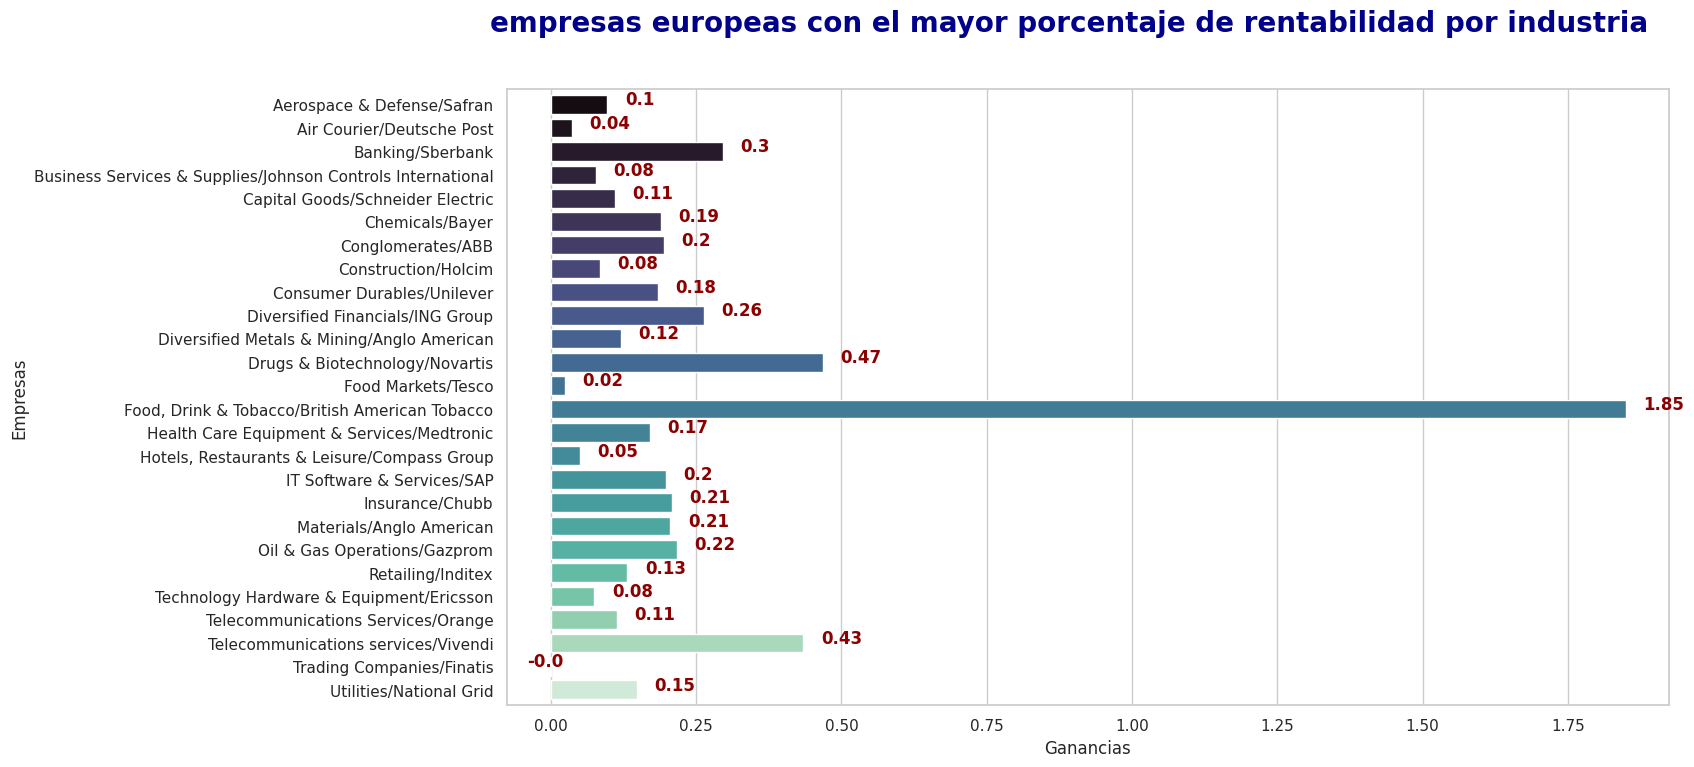

In [416]:
empresas_con_rentabilidad_por_industria_2['industria/empresa'] = pd.concat([empresas_con_rentabilidad_por_industria_2['Industria'], empresas_con_rentabilidad_por_industria_2['Empresa']], axis=1).apply('/'.join, axis=1)
config_empresas_con_rentabilidad_por_industria_2 = {
  'barplot_x' : empresas_con_rentabilidad_por_industria_2.Margen_Rentabilidad,
  'barplot_y' : empresas_con_rentabilidad_por_industria_2['industria/empresa'],
  'title': 'empresas europeas con el mayor porcentaje de rentabilidad por industria',
  'subtitle': '',
  'barplot_palette' : 'mako',
  'title_color' : 'darkblue',
  'xlabel': 'Ganancias',
  'ylabel': 'Empresas',
  'distancia_resultado_numerico': 0.03
}

graficar_barras(config_empresas_con_rentabilidad_por_industria_2, 'h')

In [417]:
# 6. ¿Cuáles fueron las 10 empresas norteamericanas con  mayores pérdidas registradas por industria a nivel global?
top_10_USA_mas_perdidas_2 = df_presentation.query("Nombre_Continente == 'North America'")
top_10_USA_mas_perdidas_2 = top_10_USA_mas_perdidas_2.loc[top_10_USA_mas_perdidas_2.groupby('Industria')['Margen_Rentabilidad'].idxmin().head(10)]
top_10_USA_mas_perdidas_2

,Rank_nr,Empresa,Industria,Pais,Ingresos,Ganancias,Activos,Valor_Mercado,Margen_Rentabilidad,ROA,Año,Nombre_Pais,Codigo_Pais,Nombre_Continente,Empleados
1859,381,Boeing,Aerospace & Defense,United States,58161.0,-11873.0,152136.0,144848.0,-0.204140,-0.078042,2021,United States,USA,North America,141000
433,260,FedEx,Air Courier,United States,49500.0,1136.0,37819.0,44644.0,0.022949,0.030038,2016,United States,USA,North America,323035
181,338,Delta Air Lines,Airline,United States,40315.0,659.0,54121.0,34422.0,0.016346,0.012176,2015,United States,USA,North America,79655
1051,374,Citigroup,Banking,United States,90469.0,-5838.0,1922104.0,185788.0,-0.064530,-0.003037,2018,United States,USA,North America,209000
1075,464,DXC Technology,Business Services & Supplies,United States,20151.0,1043.0,33582.0,29883.0,0.051759,0.031058,2018,United States,USA,North America,150000
791,503,Caterpillar,Capital Goods,United States,38537.0,-67.0,74704.0,56021.0,-0.001739,-0.000897,2017,United States,USA,North America,95400
1641,572,Dow,Chemicals,United States,41752.0,-1682.0,60686.0,27249.0,-0.040285,-0.027716,2020,United States,USA,North America,36500
1332,389,General Electric,Conglomerates,United States,121615.0,-22367.0,317688.0,81435.0,-0.183916,-0.070406,2019,United States,USA,North America,283000
1842,321,CRH,Construction,United States,27536.0,1116.5,44944.0,38177.0,0.040547,0.024842,2021,United States,USA,North America,77100
1066,439,General Motors,Consumer Durables,United States,144421.0,-3182.0,218726.0,51994.0,-0.022033,-0.014548,2018,United States,USA,North America,180000


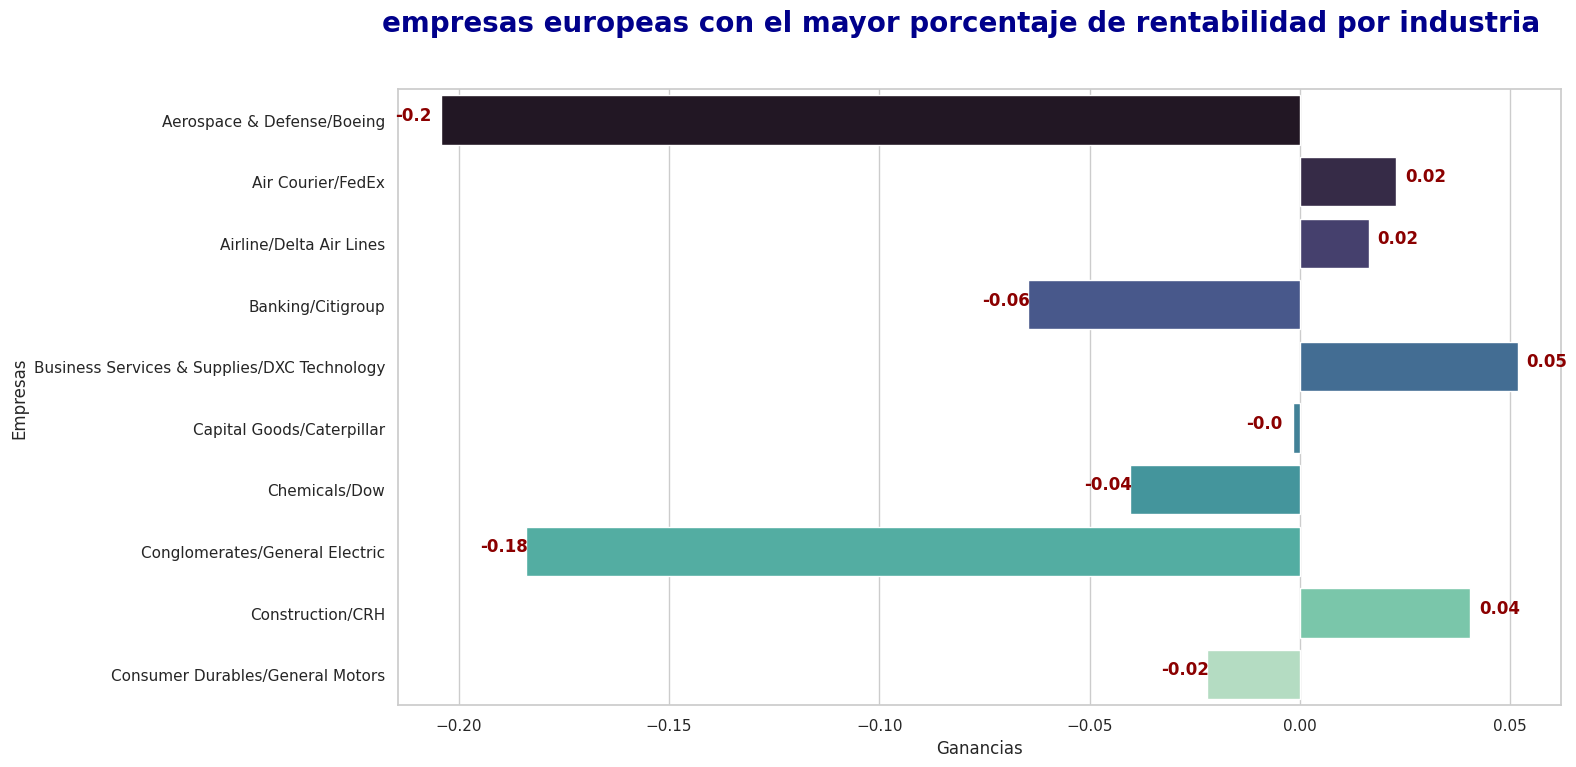

In [420]:
top_10_USA_mas_perdidas_2['industria/empresa'] = pd.concat([top_10_USA_mas_perdidas_2['Industria'], top_10_USA_mas_perdidas_2['Empresa']], axis=1).apply('/'.join, axis=1)
config_top_10_USA_mas_perdidas_2 = {
  'barplot_x' : top_10_USA_mas_perdidas_2.Margen_Rentabilidad,
  'barplot_y' : top_10_USA_mas_perdidas_2['industria/empresa'],
  'title': 'empresas europeas con el mayor porcentaje de rentabilidad por industria',
  'subtitle': '',
  'barplot_palette' : 'mako',
  'title_color' : 'darkblue',
  'xlabel': 'Ganancias',
  'ylabel': 'Empresas',
  'distancia_resultado_numerico': 0.002
}

graficar_barras(config_empresas_con_rentabilidad_por_industria_2, 'h')

In [ ]:
# 7. ¿Cuál fue la distribución de Ingresos y Activos con respecto a las ganancias de los bancos cuyos activos no superan los 15000 millones de dólares?
distribucion_ingresos_activos_ganancias_2 = df_presentation.query('Activos <= 1500000000 and Industria == "Banking"')[['Empresa','Ingresos', 'Activos', 'Ganancias']]
distribucion_ingresos_activos_ganancias_2

,Empresa,Ingresos,Activos,Ganancias
0,China Construction Bank,130473.0,2698925.0,37038.9
1,Agricultural Bank of China,129221.0,2574815.0,29124.5
2,Bank of China,120297.0,2458336.0,27526.8
6,Wells Fargo,90403.0,1701408.0,23057.0
10,HSBC Holdings,81086.0,2634139.0,13536.7
...,...,...,...,...
2056,Banco Bradesco,28331.0,296888.0,4066.9
2078,Deutsche Bank,36697.0,1505645.0,2657.1
2091,KB Financial Group,33856.0,560376.0,3788.1
2096,Banco do Brasil,29542.0,362533.0,3399.5


In [ ]:
# 8. ¿Cuáles fueron las ganancias anuales de las principales empresas en la Industria automotriz?
empresas = ['Toyota Motor', 'Volkswagen Group', 'General Motors', 'Ford Motor', 'Honda Motor', 'BMW Group',
             'Fiat Chrysler Automobiles', 'Hyundai Motor', 'Nissan Motor', 'Mercedes-Benz Group']
isin_list = df_presentation['Empresa'].isin(empresas)
empresas_automotrices_2 = df_presentation[isin_list]
empresas_automotrices_2

,Rank_nr,Empresa,Industria,Pais,Ingresos,Ganancias,Activos,Valor_Mercado,Margen_Rentabilidad,ROA,Año,Nombre_Pais,Codigo_Pais,Nombre_Continente,Empleados
7,11,Toyota Motor,Consumer Durables,Japan,252185.0,19120.4,389693.0,239045.0,0.075819,0.049065,2015,Japan,JPN,Asia,344109
39,63,Honda Motor,Consumer Durables,Japan,117055.0,5625.3,148670.0,61359.0,0.048057,0.037837,2015,Japan,JPN,Asia,204730
40,64,General Motors,Consumer Durables,United States,155929.0,3949.0,177677.0,59036.0,0.025326,0.022226,2015,United States,USA,North America,216000
43,69,Ford Motor,Consumer Durables,United States,144077.0,3187.0,208527.0,63598.0,0.022120,0.015283,2015,United States,USA,North America,187000
61,96,Nissan Motor,Consumer Durables,Japan,106683.0,4286.7,138936.0,45871.0,0.040182,0.030854,2015,Japan,JPN,Asia,149388
73,117,Hyundai Motor,Consumer Durables,"Korea, South",84791.0,6979.3,133945.0,32854.0,0.082312,0.052106,2015,"Korea, South",KOR,Asia,109748
288,10,Toyota Motor,Consumer Durables,Japan,235832.0,19267.0,406692.0,176960.0,0.081698,0.047375,2016,Japan,JPN,Asia,348877
307,40,Ford Motor,Consumer Durables,United States,149558.0,7373.0,224925.0,54196.0,0.049299,0.032780,2016,United States,USA,North America,199000
310,43,General Motors,Consumer Durables,United States,152356.0,9687.0,194520.0,49552.0,0.063581,0.049800,2016,United States,USA,North America,215000
328,74,Honda Motor,Consumer Durables,Japan,118094.0,4425.8,154522.0,51090.0,0.037477,0.028642,2016,Japan,JPN,Asia,208399


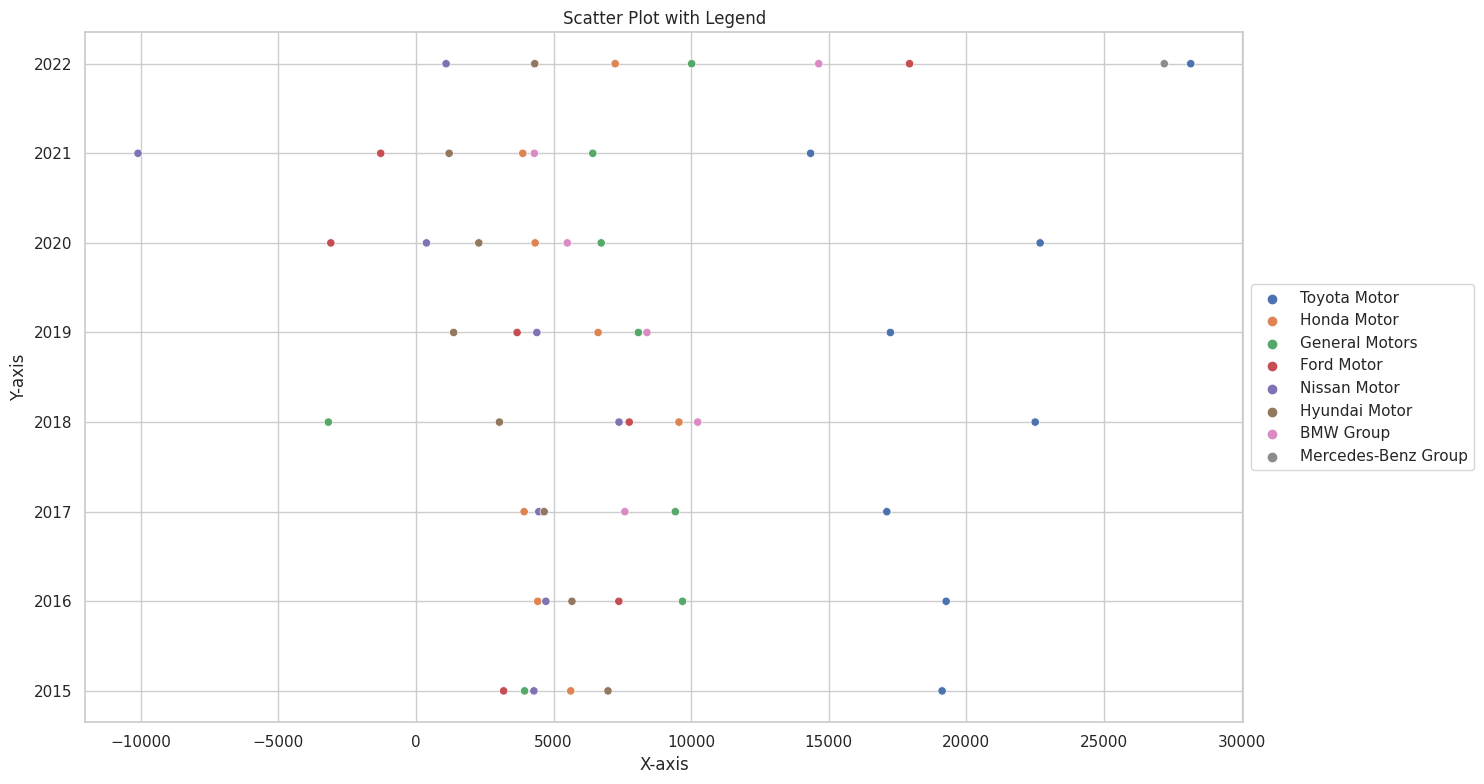

In [436]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=empresas_automotrices_2, x="Ganancias", y="Año", hue = 'Empresa')
plt.legend(loc='upper right')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Legend')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()